In [368]:
# General import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing import 
from sklearn.preprocessing import StandardScaler

# ML models
# Model imports
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Model performance
from sklearn.metrics import r2_score, root_mean_squared_error

# Optimization
from sklearn.model_selection import RandomizedSearchCV

# Deep Learning part
# General (ANN layers)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# CNN layer
from keras.layers import Conv1D 

# LSTM layer
from keras.layers import LSTM


#### Object Defination

In [390]:
feature = [
    # Raw featrues
    'AT (°C)', 
    'RH (%)', 
    'WS (m/s)', 
    'WD (deg)', 
    'RF (mm)', 
    'SR (W/mt2)', 
    'BP (mmHg)', 

    # features by time 
    'day_of_week', 
    'hour', 
    'month',
    'year',

    # weighted 
    'hour_weight', 
    'month_weight']

feature_with_lag = feature + [
        '1hr_lag',
        '2hr_lag',
        '8hr_lag',
        '1day_lag',
    ]

feature_forcast = feature + [
        '1year_lag'
    ]


target = ['PM2.5 (µg/m³)']

# target = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)']

In [345]:
# Define objects
scaler = StandardScaler()

# Best RandomForest Object
rf = RandomForestRegressor(
    random_state=42, 
    n_estimators=294,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1
)

# Best XGBoost Object
xgb_model = XGBRegressor(
    n_estimators=294,
    max_depth=20,
    learning_rate=0.025500916544420573,
    min_child_weight=2,
    subsample=0.7434753286589282,
    random_state=42
)



#### Helper Functions

In [338]:
# we dont require the following columns in the data
col_to_drop = ['NO (µg/m³)', 
               'NOx (ppb)', 
               'NH3 (µg/m³)', 
               'SO2 (µg/m³)', 
               'CO (mg/m³)',
               'Ozone (µg/m³)', 
               'Benzene (µg/m³)', 
               'Toluene (µg/m³)', 
               'Xylene (µg/m³)', 
               'O Xylene (µg/m³)', 
               'Eth-Benzene (µg/m³)', 
               'MP-Xylene (µg/m³)', 
               'TOT-RF (mm)',
               'VWS (m/s)'
              ]

In [337]:
# name formate
prefix = "Raw_data_1Hr_"
name_map = {
       0: "1422_Dwarka-Sector_8_Delhi_DPCC_",
       1: "106_IGI_Airport_(T3)_Delhi_IMD",
       2: "117_ITO_Delhi_CPCB",
       3: "1423_Jahangirpuri_Delhi_DPCC",
       4: "1424_Jawaharlal_Nehru_Stadium_Delhi_DPCC",
       5: "1435_Vivek_Vihar_Delhi_DPCC",
       6: "1562_Sri_Aurobindo_Marg_Delhi_DPCC"
    }
suffix = "_1Hr.csv"

def extract_name(key):
    return (name_map[int(key[1])-1].split("_", 1)[1]).split("_Delhi_")[0].replace('_', ' ')

In [ ]:
def add_new_features(df):
    df = df.copy()

    # Add time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year

    # for pm2.5
    # Month-based weights based 
    month_weights = {
        1: 1.0, 2: 0.8, 3: 0.6, 4: 0.4, 5: 0.2, 6: 0.1,
        7: 0.1, 8: 0.1, 9: 0.2, 10: 0.6, 11: 0.9, 12: 1.0
    }
    # Hour-based weights
    hour_weights = {
        0: 0.9, 1: 0.9, 2: 0.9, 3: 0.9, 4: 0.8, 5: 0.7, 6: 0.6,
        7: 0.5, 8: 0.5, 9: 0.4, 10: 0.3, 11: 0.3, 12: 0.3,
        13: 0.3, 14: 0.2, 15: 0.2, 16: 0.3, 17: 0.4, 18: 0.5,
        19: 0.6, 20: 0.7, 21: 0.8, 22: 0.9, 23: 0.9
    }
    # map them 
    df['month_weight'] = df['month'].map(month_weights)
    df['hour_weight'] = df['hour'].map(hour_weights)


    # lag and roll features
    # Create a continuous hourly index
    continuous_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

    # Reindex the DataFrame
    df_reindexed = df.reindex(continuous_index)

    # Create the lag feature
    df_reindexed['1hr_lag'] = df_reindexed['PM2.5 (µg/m³)'].shift(1)
    df_reindexed['2hr_lag'] = df_reindexed['PM2.5 (µg/m³)'].shift(2)
    df_reindexed['8hr_lag'] = df_reindexed['PM2.5 (µg/m³)'].shift(3)
    df_reindexed['1day_lag'] = df_reindexed['PM2.5 (µg/m³)'].shift(24)

    # create roll features


    # drop na with raw_feature  as na
    df_reindexed.dropna(subset = feature + target, inplace=True)

    

    return df_reindexed

In [388]:
def data_split(df, train_size=0.8):
    split_index = int(len(df) * train_size)

    train_data = df[:split_index]
    test_data = df[split_index:]

    return train_data, test_data

In [389]:
def scale_and_split(df, fe=feature, targ=target, train_size=0.8):

    train_data, test_data = data_split(df, train_size)
    # Separate features (X) and target (y)

    X_train = scaler.fit_transform(train_data[fe])
    y_train = scaler.fit_transform(train_data[targ])
    X_test = scaler.fit_transform(test_data[fe])
    y_test = scaler.fit_transform(test_data[targ])

    return X_train, X_test, y_train, y_test


In [361]:
def graph_performance(results):   
    result_df = pd.DataFrame(results).T
    # set name for each
    result_df.set_index((np.array(extract_name(name)) for name in result_df.index), 
                        inplace=True)

    # Rows to have the 
    metrics = ['R2 Test', 'R2 Train', 'MSE Test']
    df_metrics = result_df[metrics]
    # number of training rows
    no_train_rows = result_df['Train rows']

    # plot
    ax = df_metrics.plot(kind='bar', figsize=(10, 6), width=0.8, alpha=0.8)
    plt.title('Performance', fontsize=16)
    plt.xticks(rotation=0, fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    # Show no. of training rows
    for idx, train_row in enumerate(no_train_rows):
        plt.text(x=idx, y=-0.09, s=f'Training data: {train_row}', ha='center', fontsize=8, transform=ax.transData)

    # show plot
    plt.show()

In [ ]:
def clean_na(data):
    pure_data = data.dropna()
    print(f'data have total rows: {data.shape[0]}\nafter removing all null: {pure_data.shape[0]}')

    # We can also do the interpolation
    # extended_data = data[feature + target].interpolate(method='polynomial', order=3).dropna()
    # print(f'Making new data with rows: {extended_data.shape[0]}\n(interploting order 3 and drop na)')
    
    return pure_data


In [432]:
def plot_train_val_loss(history, name):
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(name + "Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [437]:
def plot_learning(train_x_ax, train_y_ax, train_pred_y, test_x_ax, test_y_ax, test_pred_y, name):
    plt.figure(figsize=(12, 6))
    # Training data
    plt.subplot(1, 2, 1)
    plt.plot(train_x_ax, train_y_ax, label='Actual', alpha=0.6, color='blue')
    plt.plot(train_x_ax, train_pred_y, label='Predicted', alpha=0.5, color='red')
    plt.title(name + ': Training Data')
    plt.xlabel('Time')
    plt.ylabel('PM2.5')
    plt.legend()

    # Testing data
    plt.subplot(1, 2, 2)
    plt.plot(test_x_ax, test_y_ax, label='Actual', alpha=0.6, color='blue')
    plt.plot(test_x_ax, test_pred_y, label='Predicted', alpha=0.5, color='red')
    plt.title(name + ": Testing Data")
    plt.xlabel("Time")
    plt.ylabel("PM2.5")
    plt.legend()

    plt.tight_layout() #  automatically adjusts subplot params so that the subplot(s) fits in to the figure area
    plt.show()


# Data Merging

### important features and parameters
* AT (°C): Ambient Temperature (in degrees Celsius)
* RH (%): Relative Humidity (in percentage)
* WS (m/s): Wind Speed (in meters per second)
* WD (deg): Wind Direction (in degrees)
* RF (mm): Rainfall (in millimeters)
* SR (W/mt²): Solar Radiation (in watts per square meter)
* BP (mmHg): Barometric Pressure (in millimeters of mercury)

I have made a dict object stationData, we can access all the data form that

In [229]:
# final data dict
stationData = {}

# iterte over the folders to make the data
for i in range(len(name_map)):
    data_list = []
    for y in range(8):
        temp_data = pd.read_csv(f'Data/s{i+1}/{prefix}{2017+y}_site_{name_map[i]}{suffix}')
        temp_data.drop(col_to_drop, axis=1, inplace=True)
        data_list.append(temp_data)
    stationData[f's{i+1}'] = pd.concat(data_list, ignore_index=True)

# drop the rows with all na values, and resample to hourly basis
for key, df in stationData.items():
    df.set_index(pd.to_datetime(df['Timestamp']), inplace=True)
    df.drop('Timestamp', axis=1, inplace=True)
    df.dropna(how='all', inplace=True)
    stationData[key] = df.resample('h').mean()


### first submission

In [248]:
# Empty DataFrame for merged data
submit_df = pd.DataFrame()
submit_col = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)']

# Loop through each station's data
for key, df in stationData.items():
    name = extract_name(key)
    renamed_columns = {col: f'{name}_{col.split(" ")[0]}' for col in submit_col}
    df_renamed = df[submit_col].rename(columns=renamed_columns)
    
    # Merge with the main DataFrame based on the timestamp index
    if submit_df.empty:
        submit_df = df_renamed 
    else:
        submit_df = submit_df.join(df_renamed, how='outer')  
    
    # Save the data if required for future
    df.to_csv(f'{name}.csv')


save to csv

In [249]:
submit_df.to_csv('manas_230626_combined_data.csv')

save to excel

In [250]:
# Convert index to a column
submit_df_x = submit_df.reset_index()
# Timestamp column is formatted to str
submit_df_x['Timestamp'] = submit_df_x['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
submit_df_x.to_excel("manas_230626_combined_data.xlsx", index=False)


# Data Visualization

### Concentration

Below we can see that there is a clear pattern in over the months in the concentration of the pollutants, (in every station), but we cant conculude any pattern over the years

In [232]:
Raw_features = ['AT (°C)', 'RH (%)',
       'WS (m/s)', 'WD (deg)', 'RF (mm)', 'SR (W/mt2)', 'BP (mmHg)']

Dwarka-Sector_8


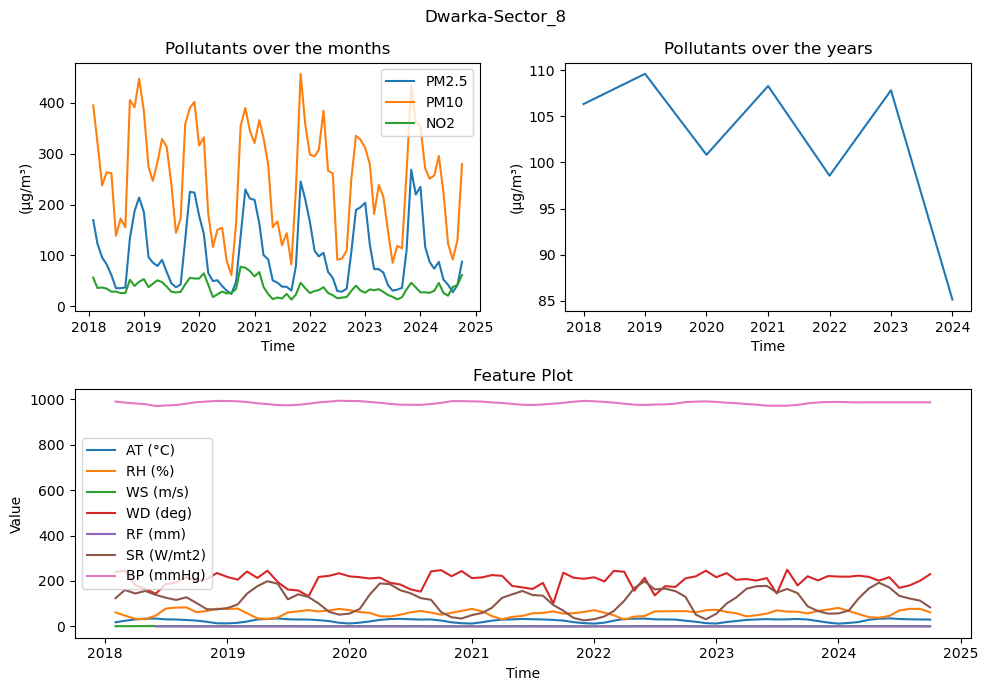

IGI_Airport_(T3)


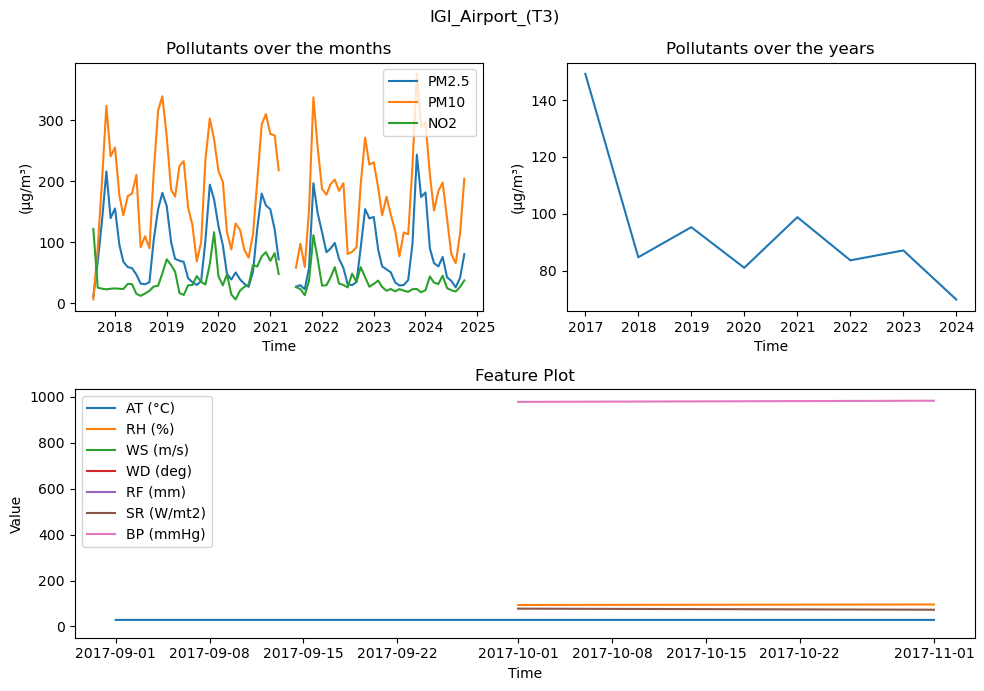

ITO


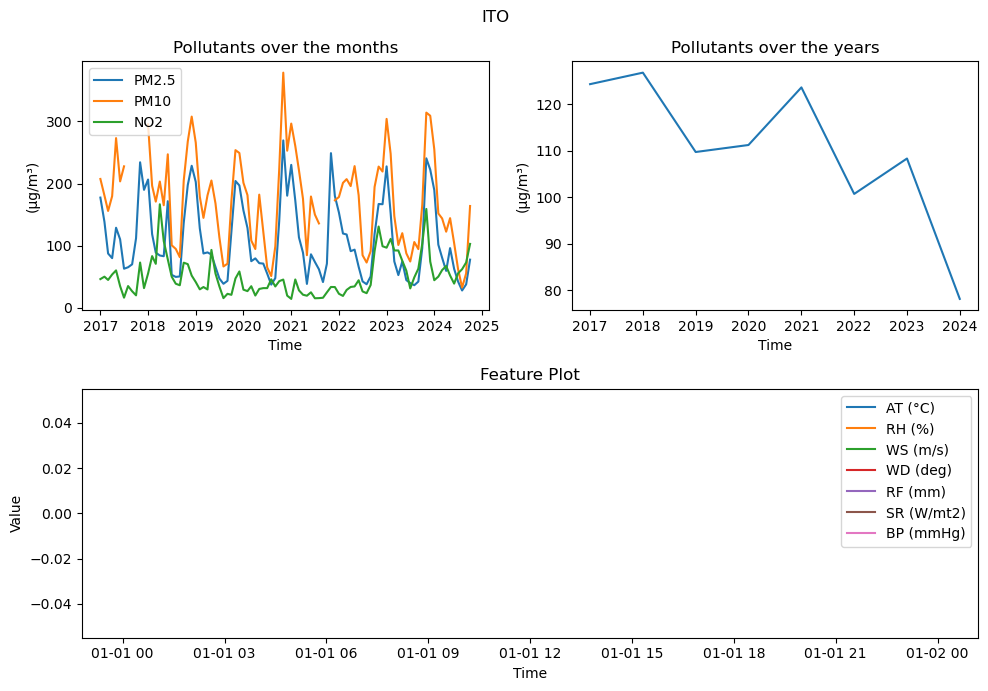

Jahangirpuri


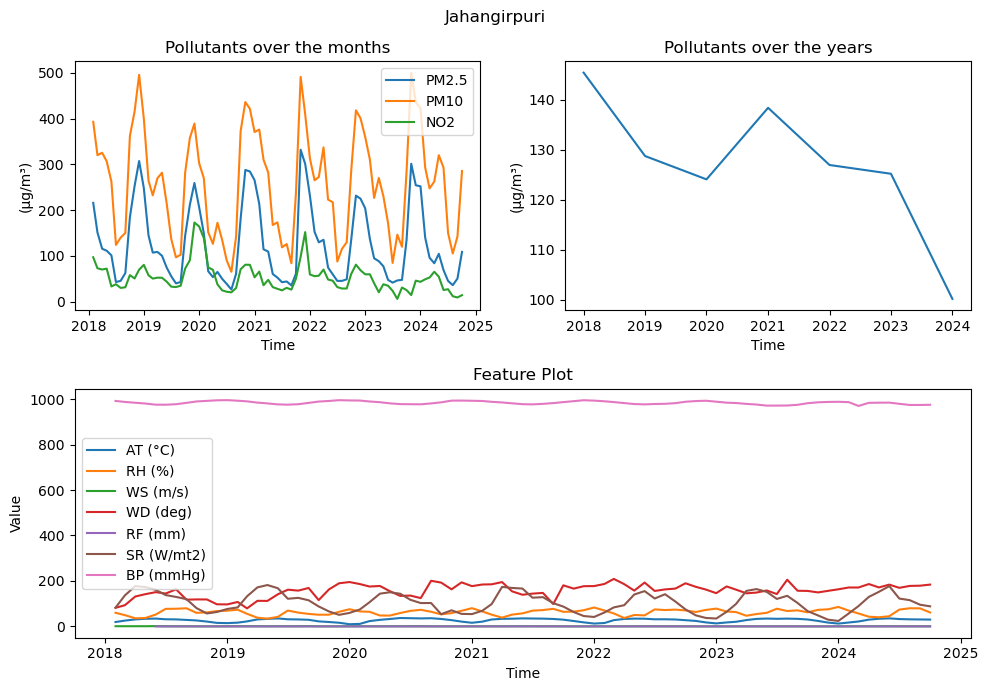

Jawaharlal_Nehru_Stadium


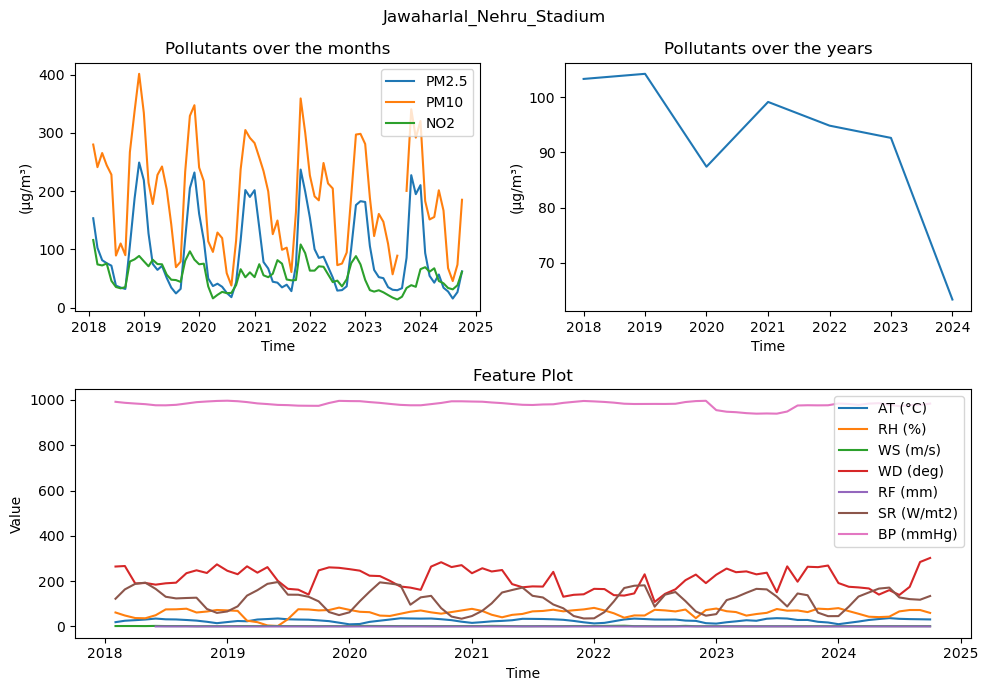

Vivek_Vihar


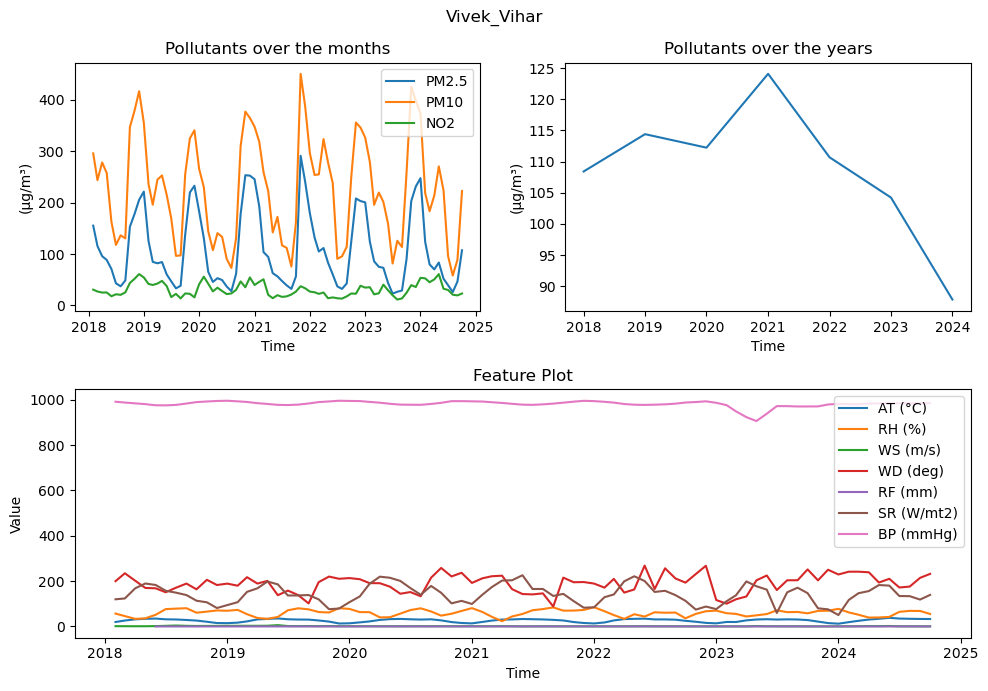

Sri_Aurobindo_Marg


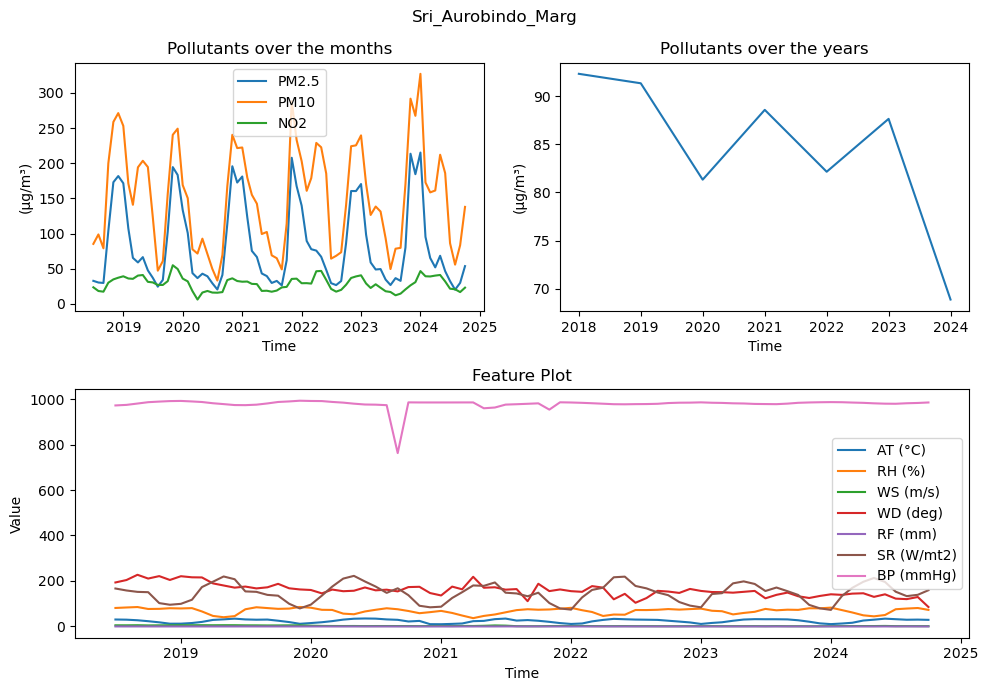

In [233]:
for key, df in stationData.items(): 
    d_m = df.resample('MS').mean()
    d_y = df.resample('YS').mean()
    
    print(extract_name(key))
    
    # changing width and height
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(7)
    
    plt.subplot(2, 2, 1) # row 1, col 2 index 1
    plt.plot(d_m.index, d_m['PM2.5 (µg/m³)'], label = "PM2.5")
    plt.plot(d_m.index, d_m['PM10 (µg/m³)'], label = "PM10")
    plt.plot(d_m.index, d_m['NO2 (µg/m³)'], label = "NO2")
    plt.title("Pollutants over the months")
    plt.xlabel('Time')
    plt.ylabel('(µg/m³)')
    plt.legend()

    plt.subplot(2, 2, 2) # row 1, col 2 index 2
    plt.plot(d_y.index, d_y['PM2.5 (µg/m³)'], label = "PM2.5")
    plt.title("Pollutants over the years")
    plt.xlabel('Time')
    plt.ylabel('(µg/m³)')

    plt.subplot(2, 1, 2)
    for f in Raw_features:
        plt.plot(d_m.index, d_m[f], label=f)
    plt.title("Feature Plot")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.suptitle(extract_name(key))
    plt.tight_layout()
    plt.show()

found out that IGI_Airport_T3 and ITO are empty data sets for features, hence dropping them

In [234]:
stationData.pop('s2')
stationData.pop('s3')
print(stationData.keys())

dict_keys(['s1', 's4', 's5', 's6', 's7'])


### By hour

# ML Model

## Random Forest

#### without lag

/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was

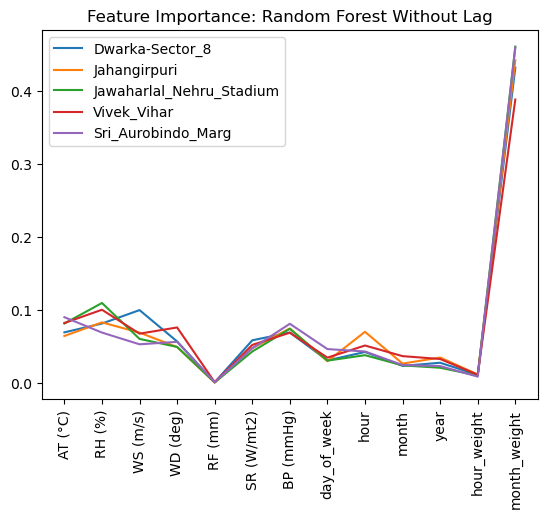

In [309]:
results = {}
for key, df in stationData.items():
    result = {}
    df = add_new_features(df)

    # without lag
    X_train, X_test, y_train, y_test = scale_and_split(df)
    # details
    result['Train rows'] = X_train.shape[0]
    result['Test rows'] = X_test.shape[0]
    # fit model
    rf.fit(X_train, y_train)
    # mesure the accuracy
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test) 
    # R2, MSE
    result['R2 Test'] = r2_score(y_test, y_test_pred)
    result['R2 Train'] = r2_score(y_train, y_train_pred)
    result['MSE Test'] = root_mean_squared_error(y_test, y_test_pred)
    result['MSE Train'] = root_mean_squared_error(y_train, y_train_pred)
    # add the result
    results[key] = result
    # plot feature importance
    plt.plot(range(X_train.shape[1]), rf.feature_importances_, label=extract_name(key))
    plt.xticks(range(X_train.shape[1]), feature, rotation=90)
    plt.title("Feature Importance: Random Forest Without Lag")
    
# Show the plot
plt.legend()
plt.show() 

#### With Lag features

/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was

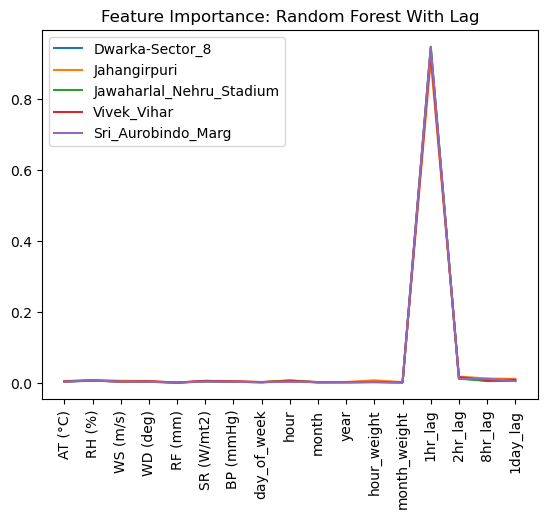

In [311]:
results_with_lag = {}
for key, df in stationData.items():
    result = {}
    df = add_new_features(df)

    # without lag
    X_train, X_test, y_train, y_test = scale_and_split(df, fe=feature_with_lag)
    # details
    result['Train rows'] = X_train.shape[0]
    result['Test rows'] = X_test.shape[0]
    # fit model
    rf.fit(X_train, y_train)
    # mesure the accuracy
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test) 
    # R2, MSE
    result['R2 Test'] = r2_score(y_test, y_test_pred)
    result['R2 Train'] = r2_score(y_train, y_train_pred)
    result['MSE Test'] = root_mean_squared_error(y_test, y_test_pred)
    result['MSE Train'] = root_mean_squared_error(y_train, y_train_pred)
    # add the result
    results_with_lag[key] = result
    # plot feature importance
    plt.plot(range(X_train.shape[1]), rf.feature_importances_, label=extract_name(key))
    plt.xticks(range(X_train.shape[1]), feature_with_lag, rotation=90)
    plt.title("Feature Importance: Random Forest With Lag")
    
# Show the plot
plt.legend()
plt.show() 

#### Performace Comparison

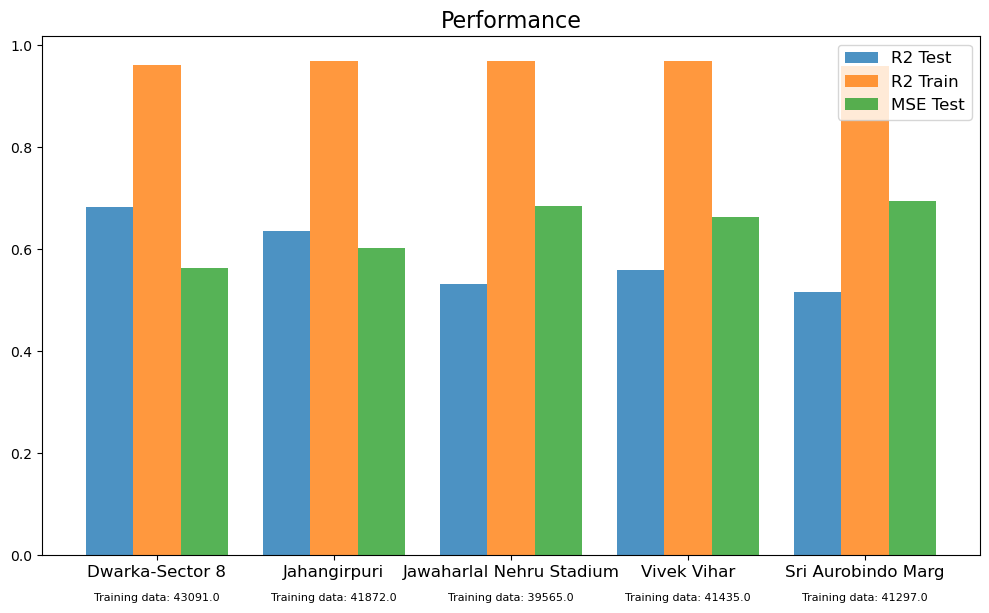

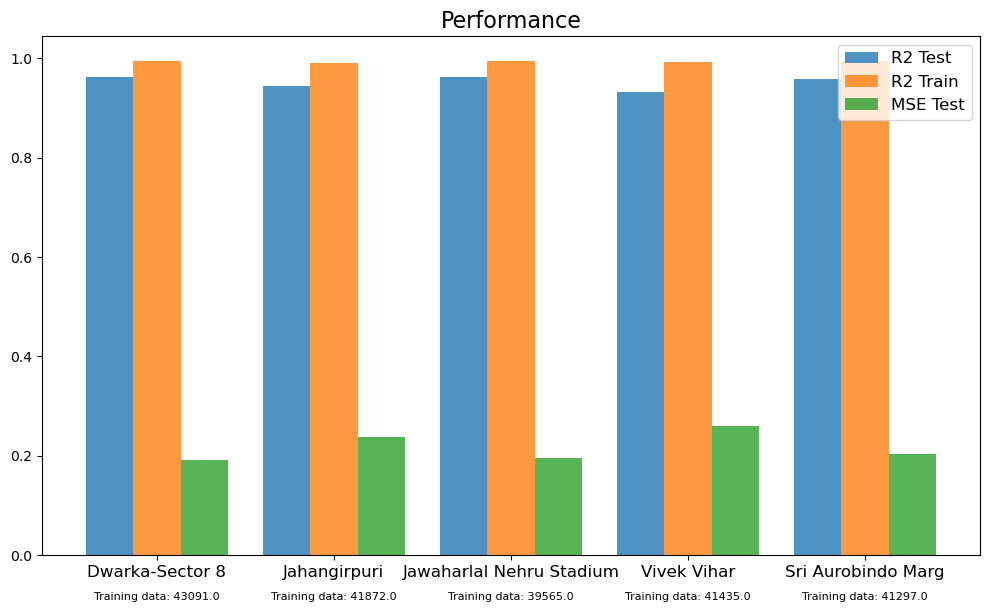

In [362]:
graph_performance(results)
graph_performance(results_with_lag)

### Randomized Search

In [261]:
param_dist = {
    "n_estimators": [300, 275, 290],
    "max_depth": [15, 20], 
    "max_features": [6, 8], 
    "min_samples_split": [1, 3],
    "min_samples_leaf": [2]

    } 

In [ ]:
random_search_rf2 = RandomizedSearchCV(rf,
                                      param_distributions=param_dist,
                                      n_iter=5,
                                      cv=5
                                      )
random_search_rf2.fit(X_train, y_train)

In [ ]:
random_search_rf2.best_score_

In [ ]:
random_search_rf2.best_params_

In [275]:
y_pred_best = random_search_rf2.best_estimator_.predict(X_test)

In [ ]:
r2_score(y_pred_best, y_test)

## XGBoost

#### Without lag

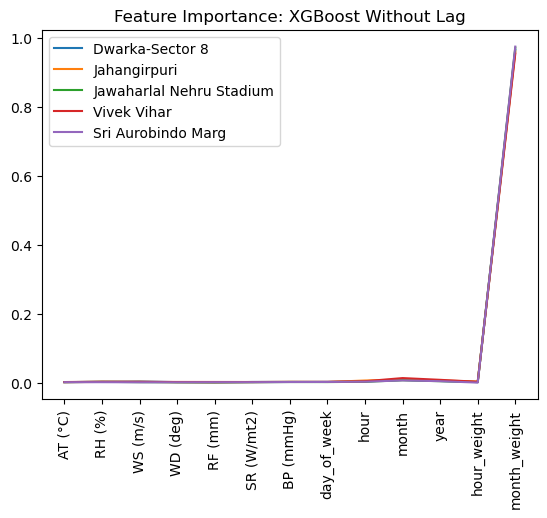

In [363]:
results_xg = {}
for key, df in stationData.items():
    result = {}
    df = add_new_features(df)

    # without lag
    X_train, X_test, y_train, y_test = scale_and_split(df)
    # details
    result['Train rows'] = X_train.shape[0]
    result['Test rows'] = X_test.shape[0]
    # fit model
    xgb_model.fit(X_train, y_train)
    # mesure the accuracy
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test) 
    # R2, MSE
    result['R2 Test'] = r2_score(y_test, y_test_pred)
    result['R2 Train'] = r2_score(y_train, y_train_pred)
    result['MSE Test'] = root_mean_squared_error(y_test, y_test_pred)
    result['MSE Train'] = root_mean_squared_error(y_train, y_train_pred)
    # add the result
    results_xg[key] = result
    # plot feature importance
    plt.plot(range(X_train.shape[1]), xgb_model.feature_importances_, label=extract_name(key))
    plt.xticks(range(X_train.shape[1]), feature, rotation=90)
    plt.title("Feature Importance: XGBoost Without Lag")
    
# Show the plot
plt.legend()
plt.show() 

#### With Lag

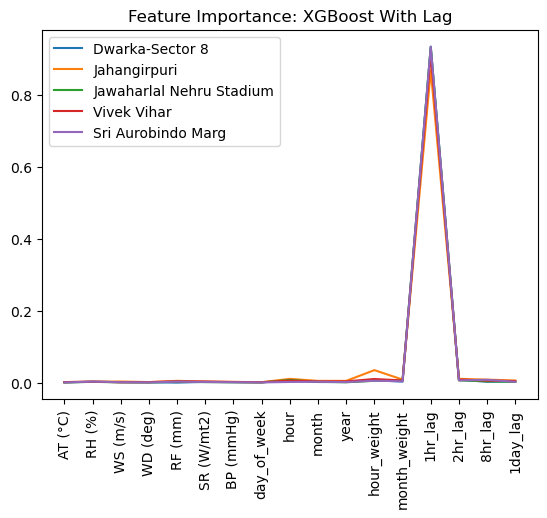

In [364]:
results_xg_with_lag = {}
for key, df in stationData.items():
    result = {}
    df = add_new_features(df)

    # without lag
    X_train, X_test, y_train, y_test = scale_and_split(df, fe=feature_with_lag)
    # details
    result['Train rows'] = X_train.shape[0]
    result['Test rows'] = X_test.shape[0]
    # fit model
    xgb_model.fit(X_train, y_train)
    # mesure the accuracy
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test) 
    # R2, MSE
    result['R2 Test'] = r2_score(y_test, y_test_pred)
    result['R2 Train'] = r2_score(y_train, y_train_pred)
    result['MSE Test'] = root_mean_squared_error(y_test, y_test_pred)
    result['MSE Train'] = root_mean_squared_error(y_train, y_train_pred)
    # add the result
    results_xg_with_lag[key] = result
    # plot feature importance
    plt.plot(range(X_train.shape[1]), xgb_model.feature_importances_, label=extract_name(key))
    plt.xticks(range(X_train.shape[1]), feature_with_lag, rotation=90)
    plt.title("Feature Importance: XGBoost With Lag")
    
# Show the plot
plt.legend()
plt.show() 

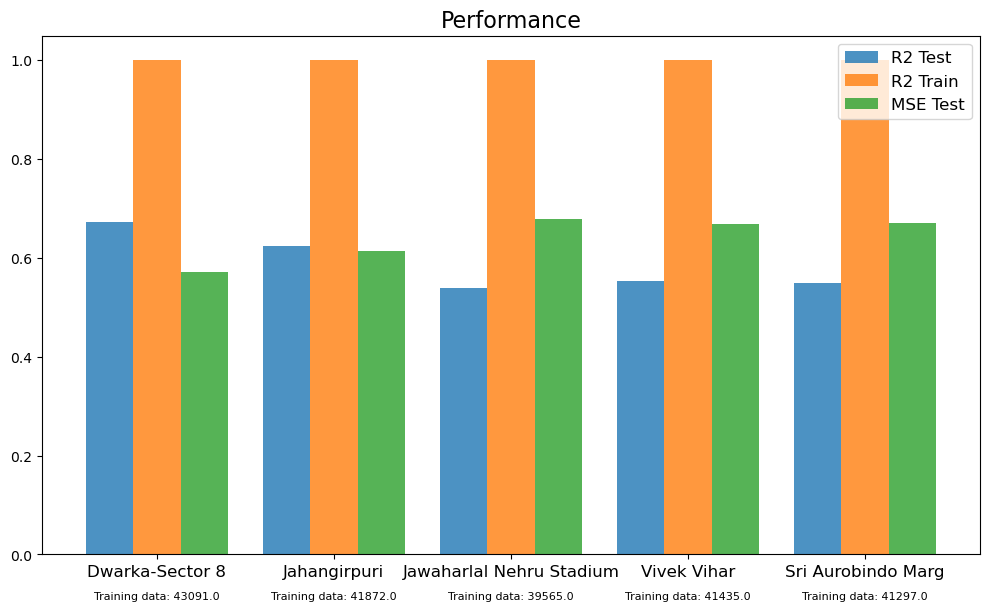

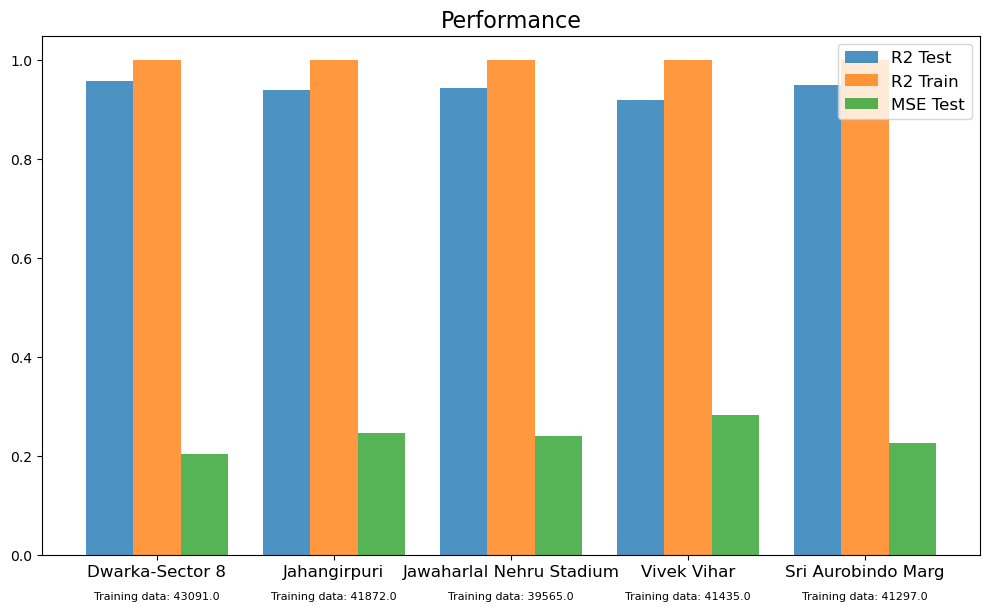

In [365]:
graph_performance(results_xg)
graph_performance(results_xg_with_lag)

# Deep Learning

#### Architecture

In [447]:
# ANN
ann_model = Sequential([
    Dense(128, activation='relu', input_dim=len(feature_with_lag)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])
# what is optimizer?
# Compile
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# CNN
cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(1, len(feature))),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])
# Compile
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

timesteps=3
# LSTM
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, len(feature)), return_sequences=True),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

### ANN

Epoch 1/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - loss: 0.5428 - mae: 0.4784 - val_loss: 0.3328 - val_mae: 0.3706
Epoch 2/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - loss: 0.4348 - mae: 0.4151 - val_loss: 0.3271 - val_mae: 0.3707
Epoch 3/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 0.4236 - mae: 0.4091 - val_loss: 0.3227 - val_mae: 0.3641
Epoch 4/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - loss: 0.3997 - mae: 0.3985 - val_loss: 0.3242 - val_mae: 0.3620
Epoch 5/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - loss: 0.3934 - mae: 0.3916 - val_loss: 0.3217 - val_mae: 0.3741
Epoch 6/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - loss: 0.3822 - mae: 0.3873 - val_loss: 0.3230 - val_mae: 0.3580
Epoch 7/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - loss: 0.3721 - mae: 0.3834 - val_loss: 0.3166 - val_mae: 0.3574
Epoch 8/10
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - loss: 0.3578 - mae: 0.3774 - val_loss: 0.3148 - val_mae: 0.3602
Epoch 9/10
1347/1347 ━━━

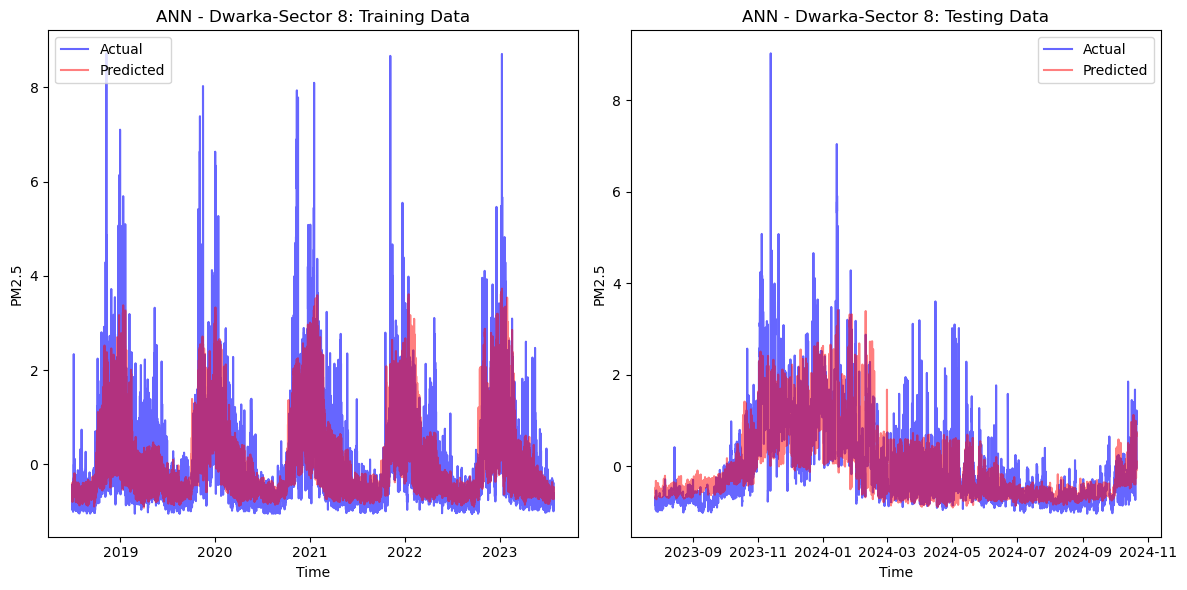

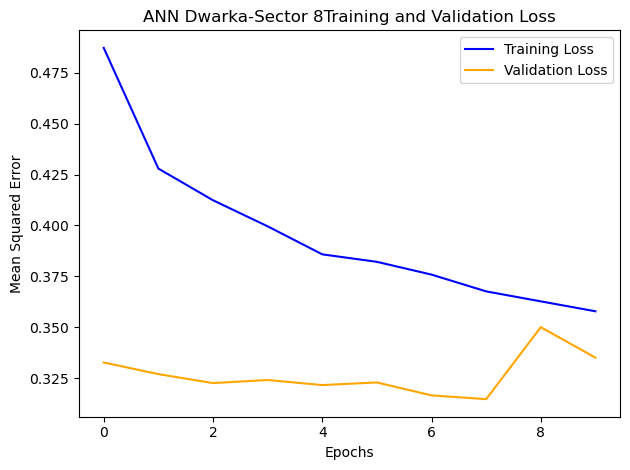

Epoch 1/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 0.3909 - mae: 0.4014 - val_loss: 0.3340 - val_mae: 0.3865
Epoch 2/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step - loss: 0.3513 - mae: 0.3775 - val_loss: 0.3408 - val_mae: 0.3854
Epoch 3/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - loss: 0.3423 - mae: 0.3723 - val_loss: 0.3487 - val_mae: 0.3925
Epoch 4/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step - loss: 0.3269 - mae: 0.3670 - val_loss: 0.3326 - val_mae: 0.3861
Epoch 5/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 0.3260 - mae: 0.3657 - val_loss: 0.3365 - val_mae: 0.3813
Epoch 6/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - loss: 0.3169 - mae: 0.3622 - val_loss: 0.3624 - val_mae: 0.4039
Epoch 7/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step - loss: 0.3137 - mae: 0.3622 - val_loss: 0.3432 - val_mae: 0.3849
Epoch 8/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - loss: 0.3084 - mae: 0.3596 - val_loss: 0.3481 - val_mae: 0.3878
Epoch 9/10
1309/1309 ━━━

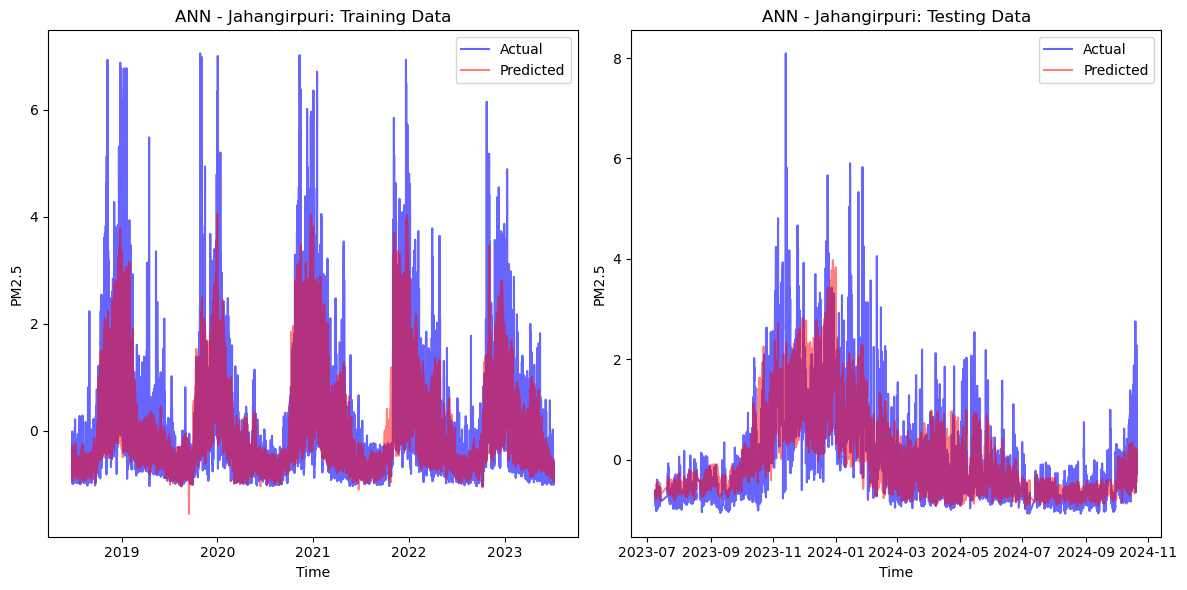

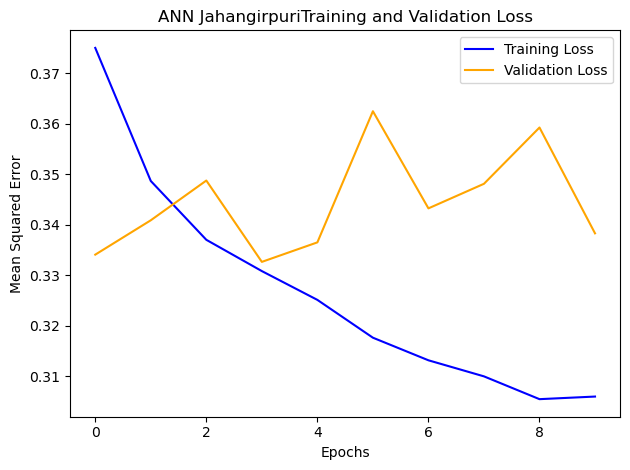

Epoch 1/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - loss: 0.4218 - mae: 0.4090 - val_loss: 0.4752 - val_mae: 0.4115
Epoch 2/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - loss: 0.3725 - mae: 0.3847 - val_loss: 0.4857 - val_mae: 0.4209
Epoch 3/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.3644 - mae: 0.3793 - val_loss: 0.4900 - val_mae: 0.4213
Epoch 4/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - loss: 0.3363 - mae: 0.3685 - val_loss: 0.5131 - val_mae: 0.4335
Epoch 5/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - loss: 0.3250 - mae: 0.3637 - val_loss: 0.4910 - val_mae: 0.4219
Epoch 6/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - loss: 0.3331 - mae: 0.3667 - val_loss: 0.5257 - val_mae: 0.4351
Epoch 7/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - loss: 0.3263 - mae: 0.3646 - val_loss: 0.4909 - val_mae: 0.4228
Epoch 8/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - loss: 0.3488 - mae: 0.3668 - val_loss: 0.4921 - val_mae: 0.4161
Epoch 9/10
1237/1237 ━━━

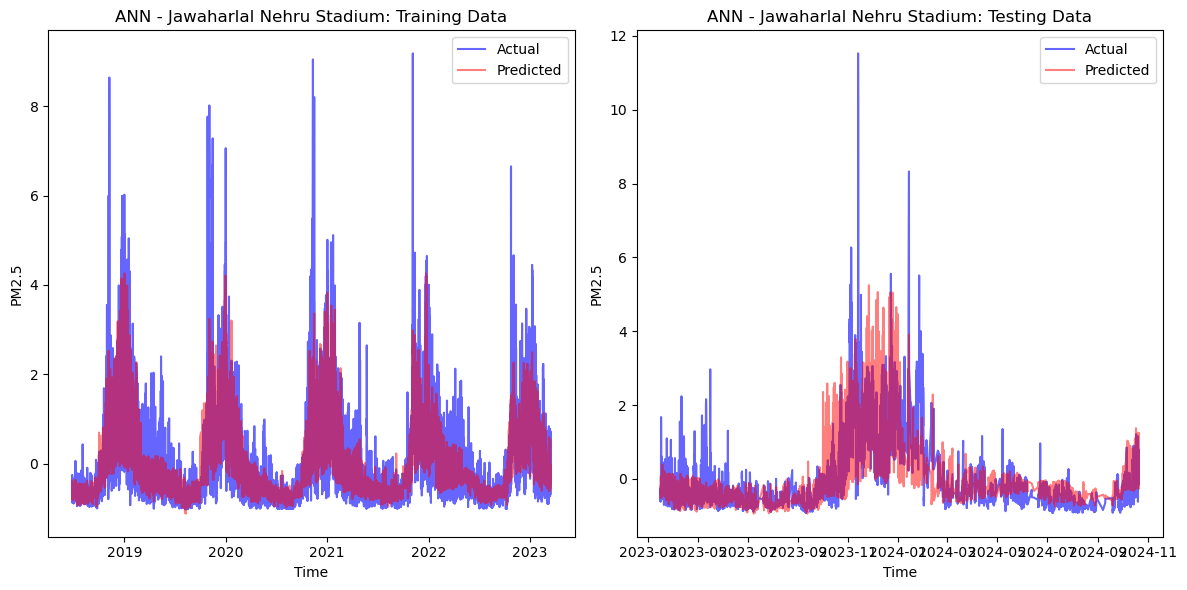

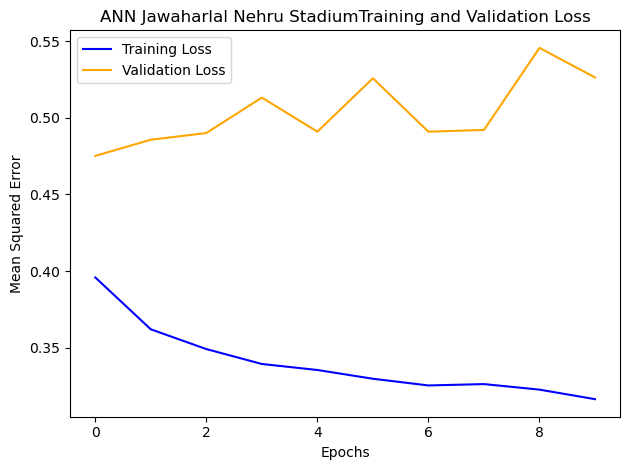

Epoch 1/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 0.4566 - mae: 0.4290 - val_loss: 0.3851 - val_mae: 0.4009
Epoch 2/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - loss: 0.4030 - mae: 0.4082 - val_loss: 0.4021 - val_mae: 0.4189
Epoch 3/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - loss: 0.3880 - mae: 0.3993 - val_loss: 0.4118 - val_mae: 0.4131
Epoch 4/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 0.3811 - mae: 0.3933 - val_loss: 0.4078 - val_mae: 0.4034
Epoch 5/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - loss: 0.3798 - mae: 0.3907 - val_loss: 0.4001 - val_mae: 0.4146
Epoch 6/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - loss: 0.3643 - mae: 0.3845 - val_loss: 0.4059 - val_mae: 0.4163
Epoch 7/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - loss: 0.3658 - mae: 0.3860 - val_loss: 0.4230 - val_mae: 0.4295
Epoch 8/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - loss: 0.3597 - mae: 0.3848 - val_loss: 0.4238 - val_mae: 0.4151
Epoch 9/10
1295/1295 ━━━

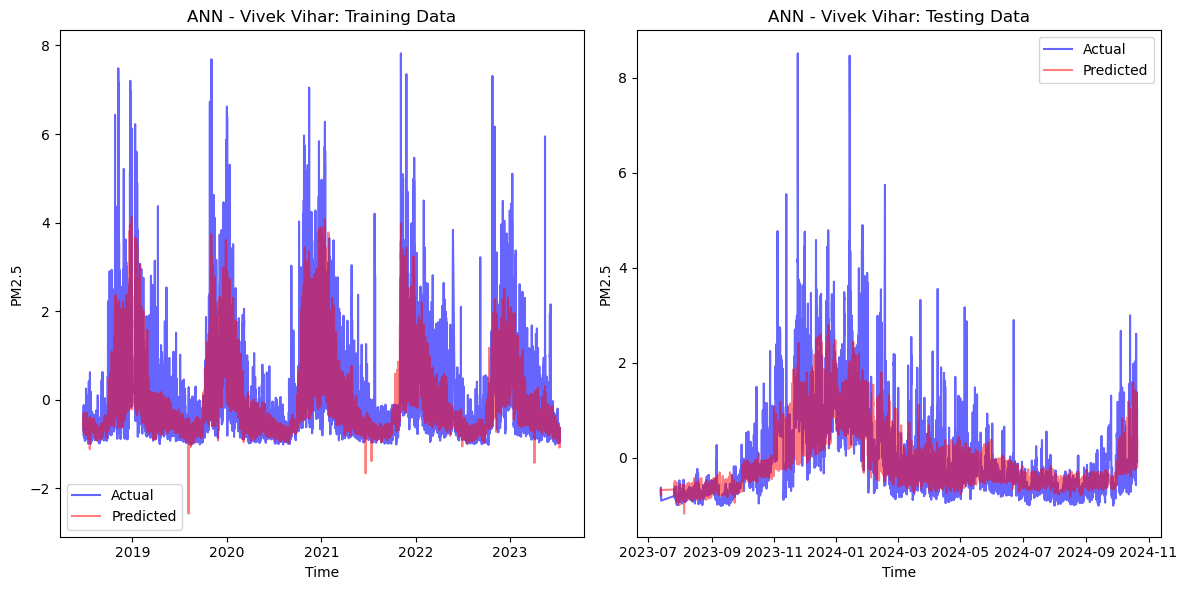

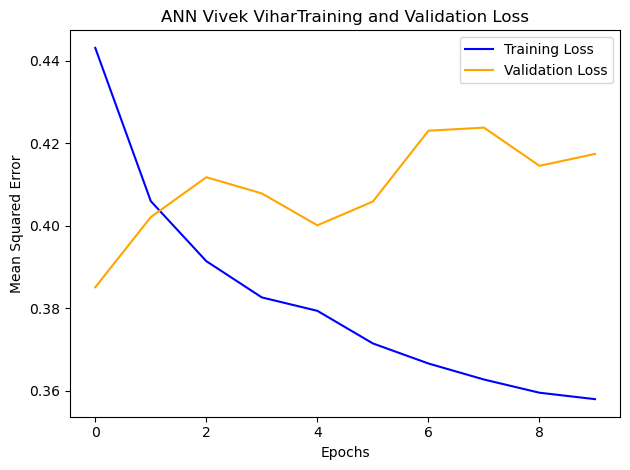

Epoch 1/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - loss: 0.4703 - mae: 0.4301 - val_loss: 0.4185 - val_mae: 0.3836
Epoch 2/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - loss: 0.4257 - mae: 0.4084 - val_loss: 0.4080 - val_mae: 0.3817
Epoch 3/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - loss: 0.4127 - mae: 0.4033 - val_loss: 0.4283 - val_mae: 0.3858
Epoch 4/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.4156 - mae: 0.4020 - val_loss: 0.4271 - val_mae: 0.3900
Epoch 5/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - loss: 0.4050 - mae: 0.3965 - val_loss: 0.4559 - val_mae: 0.3992
Epoch 6/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - loss: 0.3855 - mae: 0.3921 - val_loss: 0.4519 - val_mae: 0.3906
Epoch 7/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - loss: 0.3897 - mae: 0.3903 - val_loss: 0.4480 - val_mae: 0.3978
Epoch 8/10
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step - loss: 0.3859 - mae: 0.3884 - val_loss: 0.4426 - val_mae: 0.3891
Epoch 9/10
1291/1291 ━━━

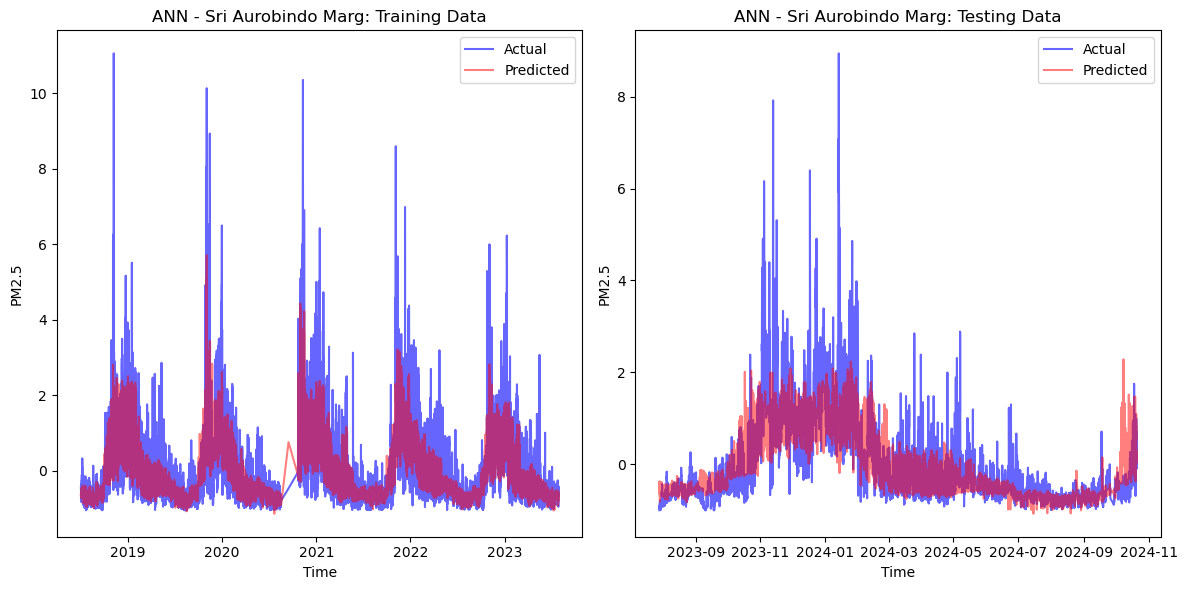

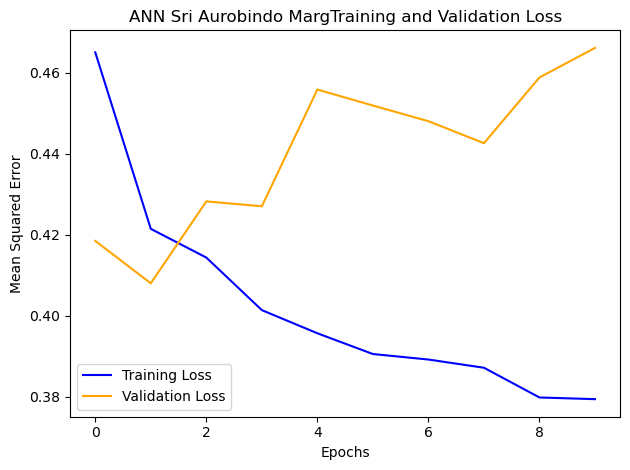

In [446]:
results_ann = {}
for key, df in stationData.items():
    result ={}
    # split data
    df = add_new_features(df)
    X_train, X_test, y_train, y_test = scale_and_split(df)
    train_data, test_data = data_split(df)

    # details
    result['Train rows'] = X_train.shape[0]
    result['Test rows'] = X_test.shape[0]

    # fit ANN model
    history = ann_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=32,
        verbose=1
    )

    # Predict
    y_train_pred = ann_model.predict(X_train).flatten()
    y_test_pred = ann_model.predict(X_test).flatten()

    # Calculate R² scores
    result['R2 Test'] = r2_score(y_test, y_test_pred)
    result['R2 Train'] = r2_score(y_train, y_train_pred)
    result['MSE Test'] = root_mean_squared_error(y_test, y_test_pred)
    result['MSE Train'] = root_mean_squared_error(y_train, y_train_pred)

    # save
    results_ann[key] = result

    # plots
    plot_learning(train_data.index, y_train, y_train_pred, test_data.index, y_test, y_test_pred, 'ANN - ' + extract_name(key))
    plot_train_val_loss(history, 'ANN ' + extract_name(key))


Epoch 1/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - loss: 0.1337 - mae: 0.2441 - val_loss: 0.0428 - val_mae: 0.1369
Epoch 2/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - loss: 0.0674 - mae: 0.1712 - val_loss: 0.0416 - val_mae: 0.1263
Epoch 3/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - loss: 0.0628 - mae: 0.1611 - val_loss: 0.0359 - val_mae: 0.1252
Epoch 4/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 0.0557 - mae: 0.1529 - val_loss: 0.0371 - val_mae: 0.1261
Epoch 5/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - loss: 0.0524 - mae: 0.1500 - val_loss: 0.0350 - val_mae: 0.1143
Epoch 6/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - loss: 0.0541 - mae: 0.1485 - val_loss: 0.0346 - val_mae: 0.1211
Epoch 7/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - loss: 0.0529 - mae: 0.1479 - val_loss: 0.0377 - val_mae: 0.1184
Epoch 8/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - loss: 0.0502 - mae: 0.1448 - val_loss: 0.0371 - val_mae: 0.1226
Epoch 9/10
1288/1288 ━━━

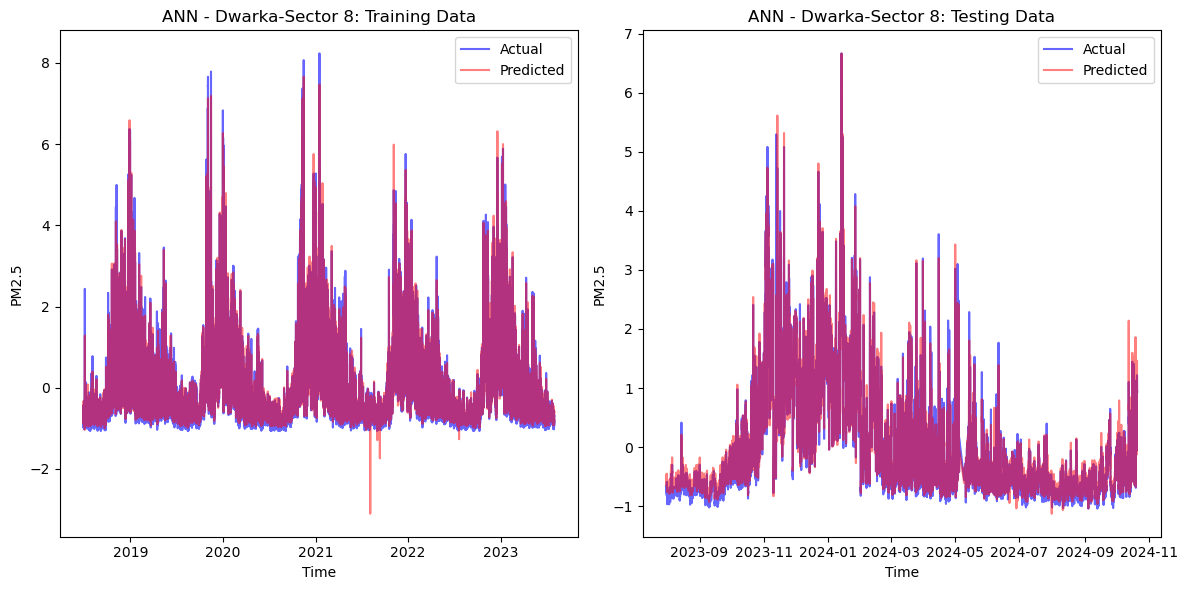

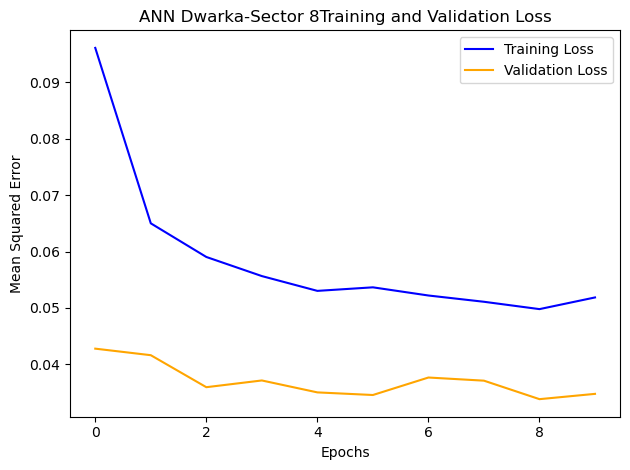

Epoch 1/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 0.0700 - mae: 0.1709 - val_loss: 0.0570 - val_mae: 0.1505
Epoch 2/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - loss: 0.0665 - mae: 0.1674 - val_loss: 0.0527 - val_mae: 0.1465
Epoch 3/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - loss: 0.0662 - mae: 0.1682 - val_loss: 0.0643 - val_mae: 0.1617
Epoch 4/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - loss: 0.0679 - mae: 0.1694 - val_loss: 0.0523 - val_mae: 0.1473
Epoch 5/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - loss: 0.0640 - mae: 0.1650 - val_loss: 0.0542 - val_mae: 0.1492
Epoch 6/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.0647 - mae: 0.1659 - val_loss: 0.0599 - val_mae: 0.1551
Epoch 7/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - loss: 0.0647 - mae: 0.1680 - val_loss: 0.0523 - val_mae: 0.1476
Epoch 8/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 0.0627 - mae: 0.1644 - val_loss: 0.0551 - val_mae: 0.1512
Epoch 9/10
1235/1235 ━━━

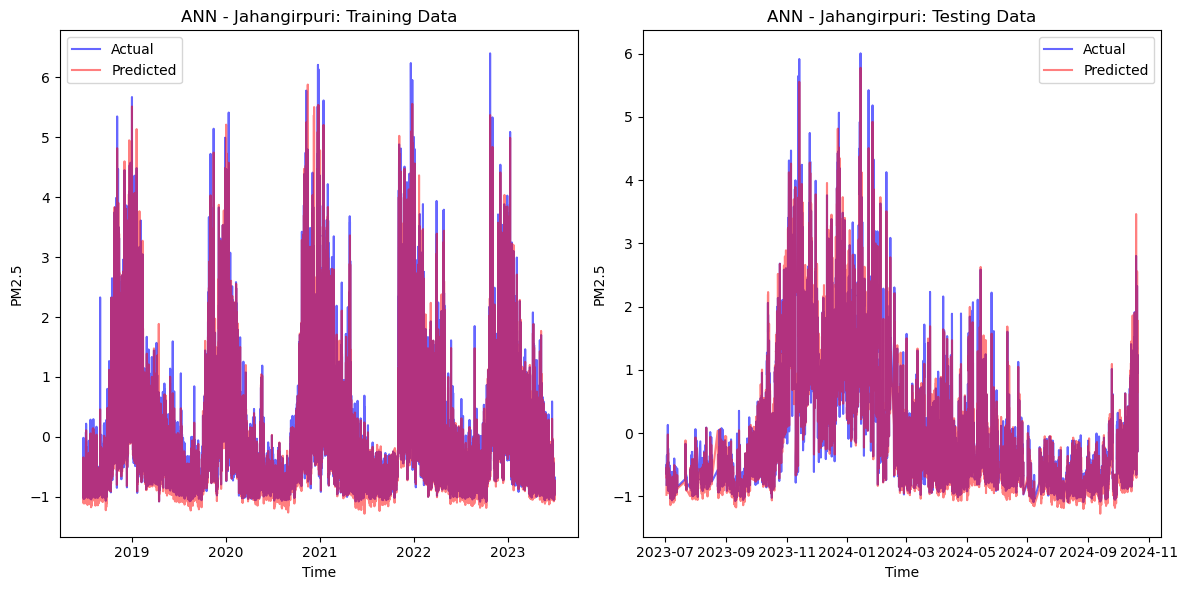

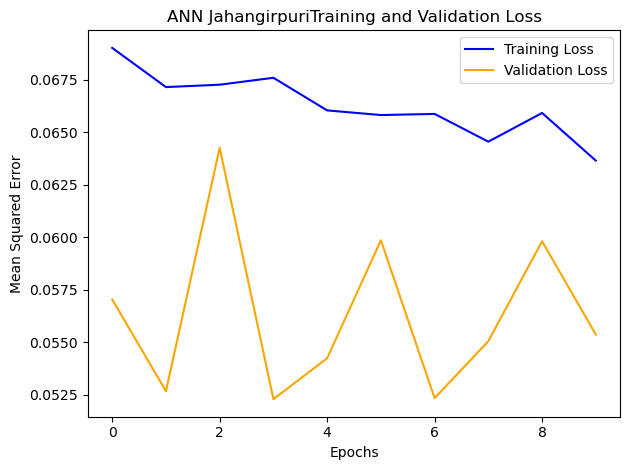

Epoch 1/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - loss: 0.0495 - mae: 0.1424 - val_loss: 0.0360 - val_mae: 0.1224
Epoch 2/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - loss: 0.0434 - mae: 0.1356 - val_loss: 0.0319 - val_mae: 0.1100
Epoch 3/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - loss: 0.0434 - mae: 0.1347 - val_loss: 0.0317 - val_mae: 0.1105
Epoch 4/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - loss: 0.0426 - mae: 0.1334 - val_loss: 0.0376 - val_mae: 0.1159
Epoch 5/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - loss: 0.0439 - mae: 0.1357 - val_loss: 0.0297 - val_mae: 0.1064
Epoch 6/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - loss: 0.0427 - mae: 0.1335 - val_loss: 0.0299 - val_mae: 0.1091
Epoch 7/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - loss: 0.0446 - mae: 0.1353 - val_loss: 0.0300 - val_mae: 0.1114
Epoch 8/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: 0.0432 - mae: 0.1336 - val_loss: 0.0321 - val_mae: 0.1139
Epoch 9/10
1147/1147 ━━━

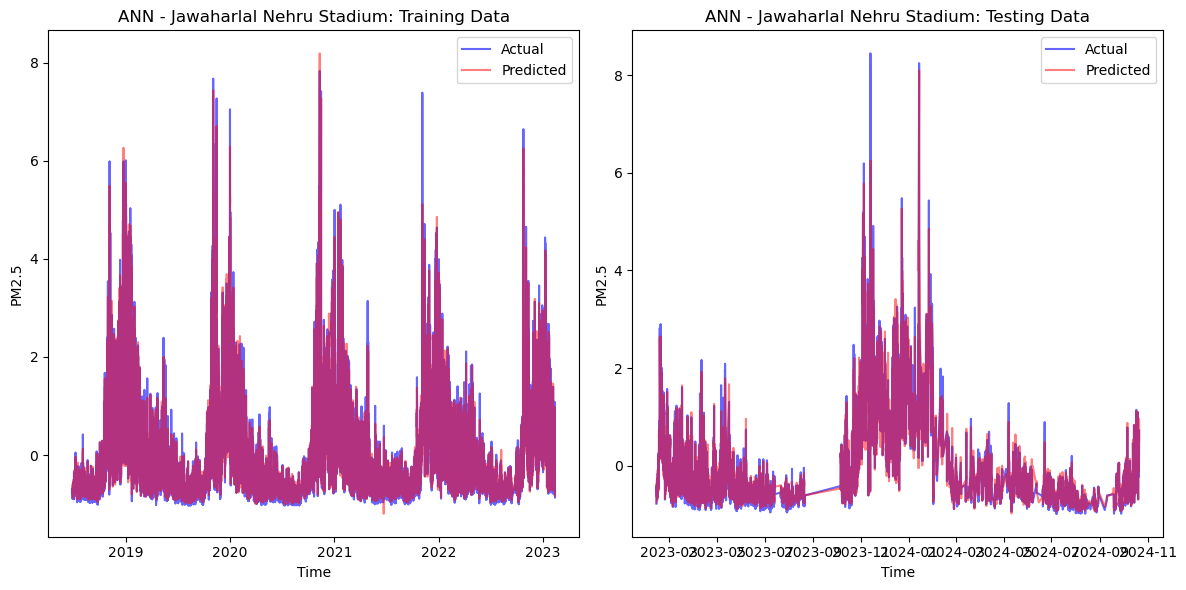

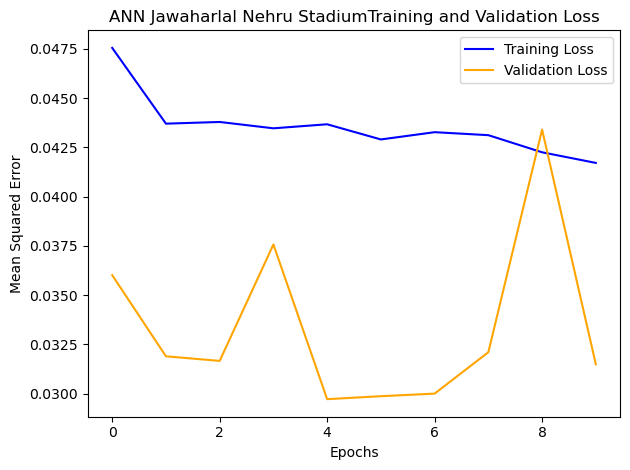

Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - loss: 0.0578 - mae: 0.1532 - val_loss: 0.0561 - val_mae: 0.1305
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 0.0548 - mae: 0.1498 - val_loss: 0.0581 - val_mae: 0.1341
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - loss: 0.0575 - mae: 0.1506 - val_loss: 0.0574 - val_mae: 0.1305
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - loss: 0.0560 - mae: 0.1496 - val_loss: 0.0580 - val_mae: 0.1302
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - loss: 0.0567 - mae: 0.1520 - val_loss: 0.0618 - val_mae: 0.1434
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - loss: 0.0527 - mae: 0.1473 - val_loss: 0.0606 - val_mae: 0.1365
Epoch 7/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - loss: 0.0548 - mae: 0.1476 - val_loss: 0.0601 - val_mae: 0.1351
Epoch 8/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: 0.0540 - mae: 0.1476 - val_loss: 0.0651 - val_mae: 0.1414
Epoch 9/10
1182/1182 ━━━

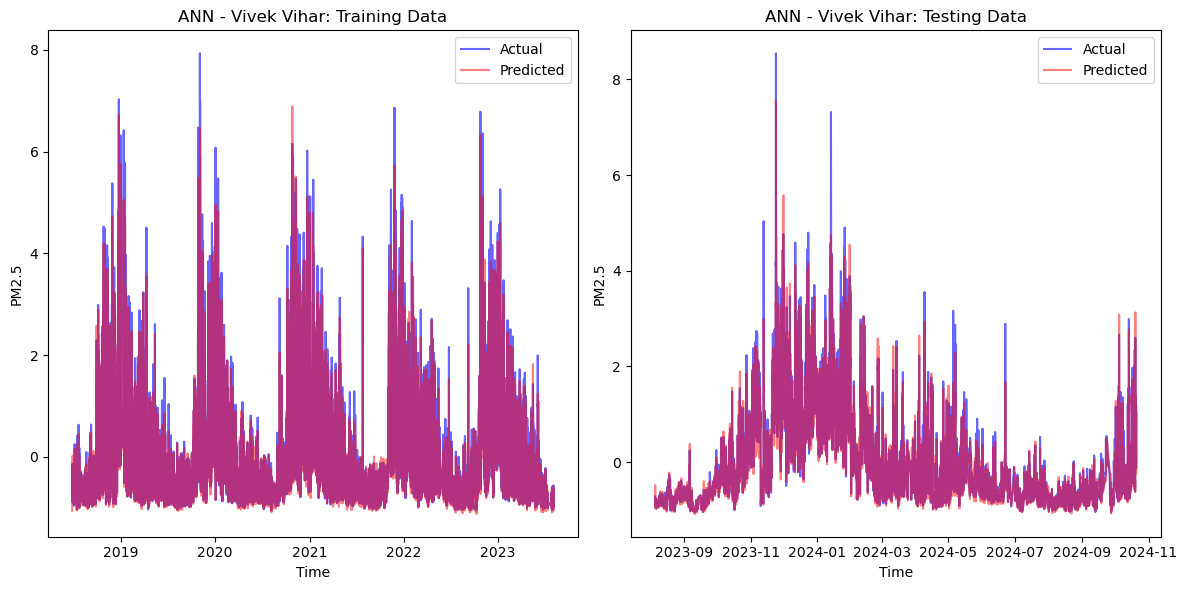

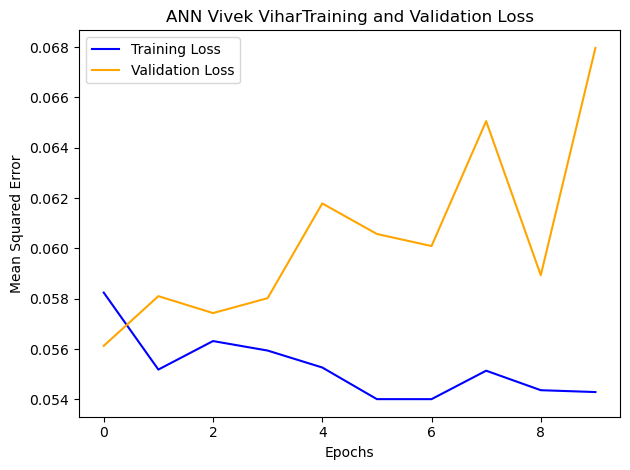

Epoch 1/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - loss: 0.0544 - mae: 0.1449 - val_loss: 0.0439 - val_mae: 0.1176
Epoch 2/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 0.0533 - mae: 0.1416 - val_loss: 0.0440 - val_mae: 0.1218
Epoch 3/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.0540 - mae: 0.1424 - val_loss: 0.0462 - val_mae: 0.1335
Epoch 4/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - loss: 0.0512 - mae: 0.1400 - val_loss: 0.0462 - val_mae: 0.1215
Epoch 5/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - loss: 0.0495 - mae: 0.1393 - val_loss: 0.0478 - val_mae: 0.1434
Epoch 6/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: 0.0468 - mae: 0.1387 - val_loss: 0.0432 - val_mae: 0.1175
Epoch 7/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - loss: 0.0464 - mae: 0.1360 - val_loss: 0.0450 - val_mae: 0.1187
Epoch 8/10
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - loss: 0.0473 - mae: 0.1383 - val_loss: 0.0428 - val_mae: 0.1165
Epoch 9/10
1243/1243 ━━━

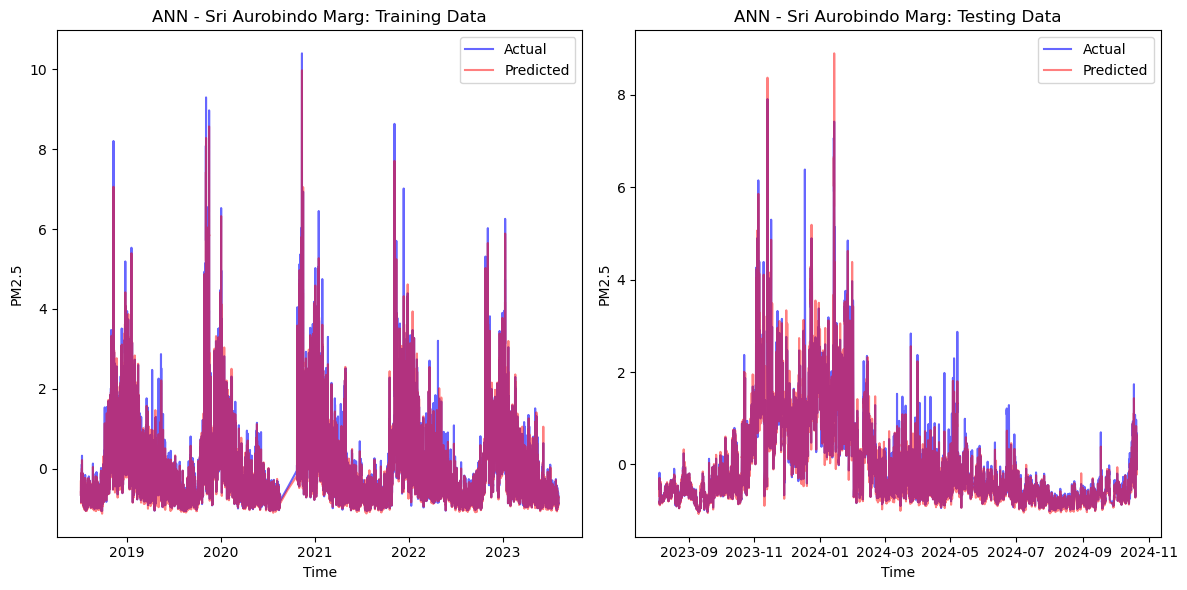

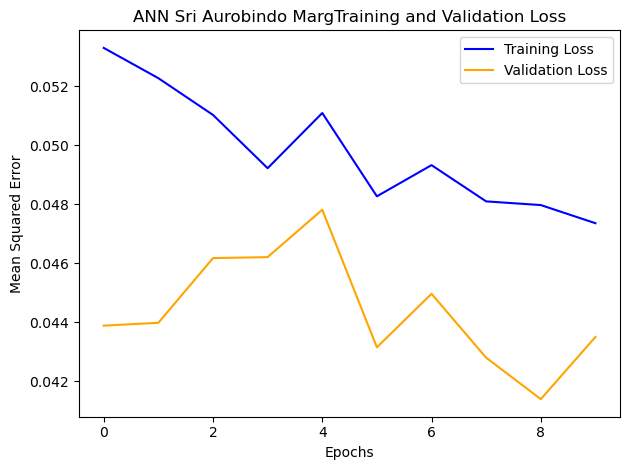

In [448]:
results_ann_lag = {}
for key, df in stationData.items():
    result ={}
    # split data
    df = add_new_features(df)
    df.dropna(inplace=True)
    X_train, X_test, y_train, y_test = scale_and_split(df, feature_with_lag)
    train_data, test_data = data_split(df)

    # details
    result['Train rows'] = X_train.shape[0]
    result['Test rows'] = X_test.shape[0]

    # fit ANN model
    history = ann_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=32,
        verbose=1
    )

    # Predict
    y_train_pred = ann_model.predict(X_train).flatten()
    y_test_pred = ann_model.predict(X_test).flatten()

    # Calculate R² scores
    result['R2 Test'] = r2_score(y_test, y_test_pred)
    result['R2 Train'] = r2_score(y_train, y_train_pred)
    result['MSE Test'] = root_mean_squared_error(y_test, y_test_pred)
    result['MSE Train'] = root_mean_squared_error(y_train, y_train_pred)

    # save
    results_ann_lag[key] = result

    # plots
    plot_learning(train_data.index, y_train, y_train_pred, test_data.index, y_test, y_test_pred, 'ANN - ' + extract_name(key))
    plot_train_val_loss(history, 'ANN ' + extract_name(key))


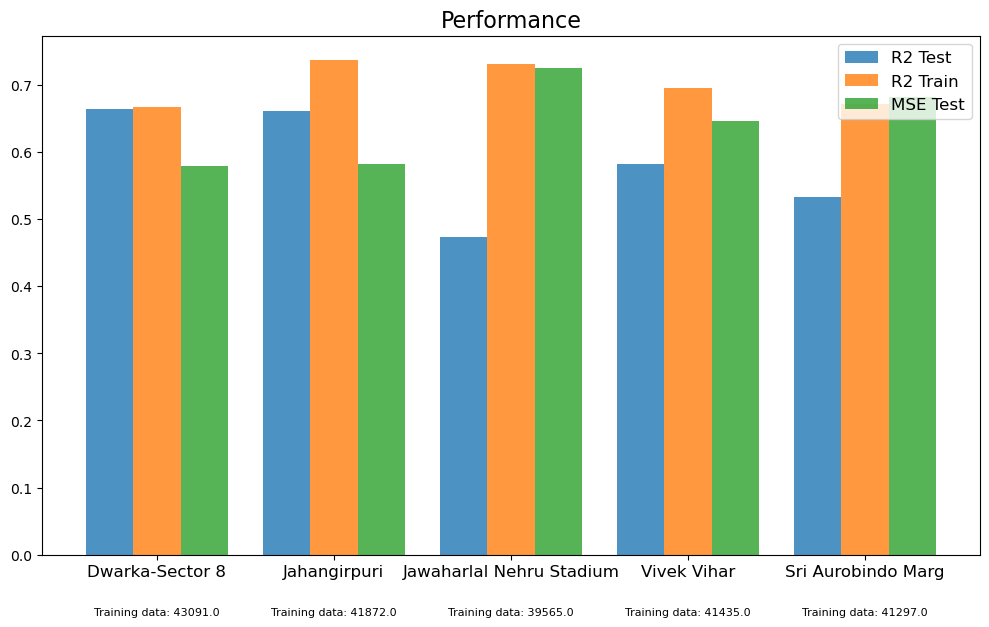

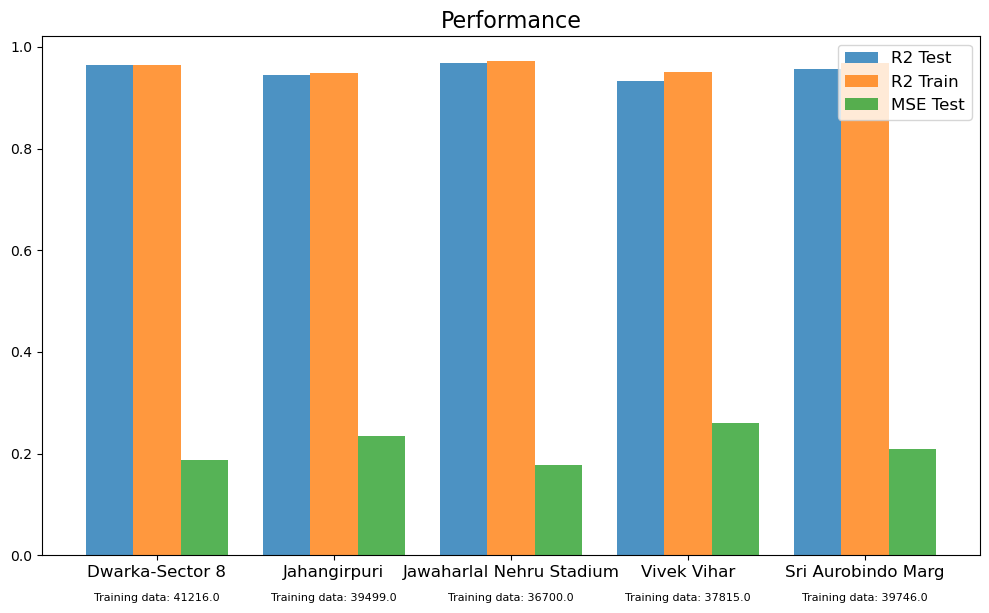

In [449]:
graph_performance(results_ann)
graph_performance(results_ann_lag)

### CNN

In [96]:
# Reshape data for CNN: (samples, timestemp, features)
X_train_cnn = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_cnn = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


In [101]:
# Train model
history2 = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
) 

Epoch 1/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - loss: 8733.7969 - mae: 66.6246 - val_loss: 5868.7046 - val_mae: 46.7469
Epoch 2/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - loss: 5493.4692 - mae: 49.5257 - val_loss: 5067.5244 - val_mae: 42.7527
Epoch 3/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: 5089.5933 - mae: 46.6895 - val_loss: 4481.9121 - val_mae: 44.5492
Epoch 4/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - loss: 4849.5151 - mae: 45.2850 - val_loss: 4622.8374 - val_mae: 40.9203
Epoch 5/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 4851.2051 - mae: 44.9996 - val_loss: 4864.2285 - val_mae: 41.1690
Epoch 6/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - loss: 4683.2378 - mae: 44.2872 - val_loss: 4464.0806 - val_mae: 39.5961
Epoch 7/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - loss: 4783.8745 - mae: 44.1588 - val_loss: 4129.7280 - val_mae: 38.7568
Epoch 8/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - loss: 4349.4619 - mae: 42.6802 -

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
CNN Train R²: 0.5325100421905518
CNN Test R²: 0.5584043264389038


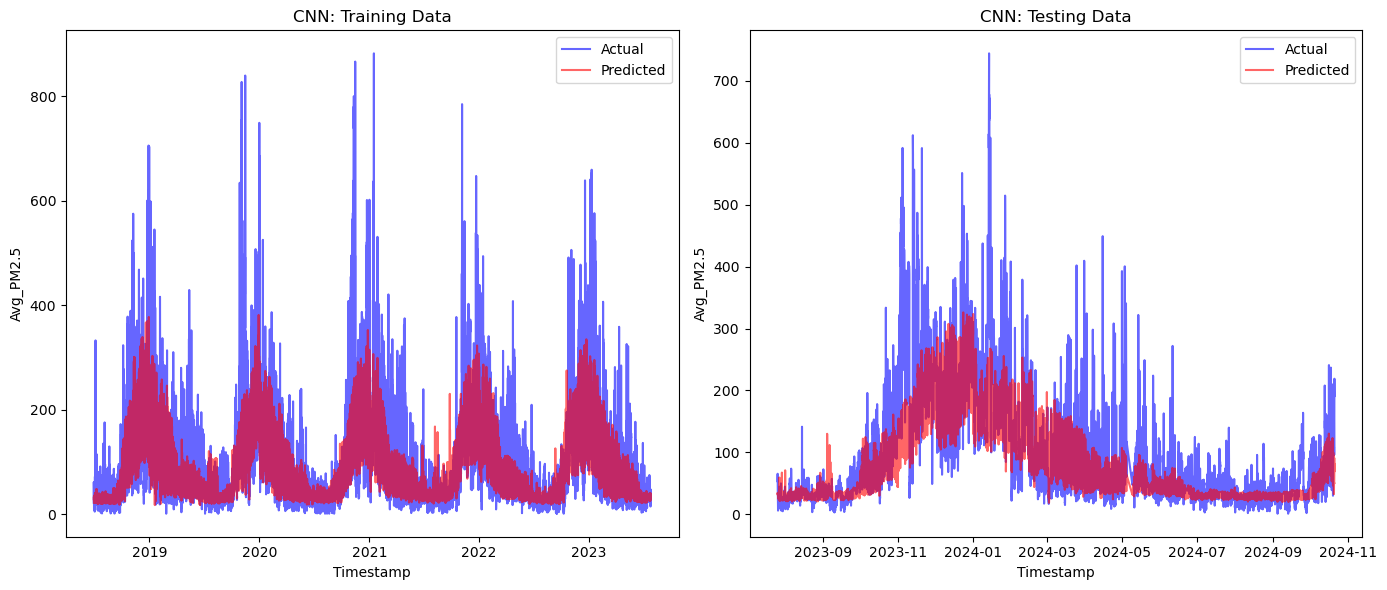

In [102]:
# Make predictions
y_train_pred_cnn = cnn_model.predict(X_train_cnn).flatten()
y_test_pred_cnn = cnn_model.predict(X_test_cnn).flatten()

# Calculate R² scores
r2_train_cnn = r2_score(y_train, y_train_pred_cnn)
r2_test_cnn = r2_score(y_test, y_test_pred_cnn)

print(f"CNN Train R²: {r2_train_cnn}")
print(f"CNN Test R²: {r2_test_cnn}")

# Visualization for CNN
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
plt.plot(train_data.index, y_train, label='Actual', alpha=0.6, color='blue')
plt.plot(train_data.index, y_train_pred_cnn, label='Predicted', alpha=0.6, color='red')
plt.title("CNN: Training Data")
plt.xlabel("Timestamp")
plt.ylabel("Avg_PM2.5")
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.plot(test_data.index, y_test, label='Actual', alpha=0.6, color='blue')
plt.plot(test_data.index, y_test_pred_cnn, label='Predicted', alpha=0.6, color='red')
plt.title("CNN: Testing Data")
plt.xlabel("Timestamp")
plt.ylabel("Avg_PM2.5")
plt.legend()

plt.tight_layout()
plt.show()


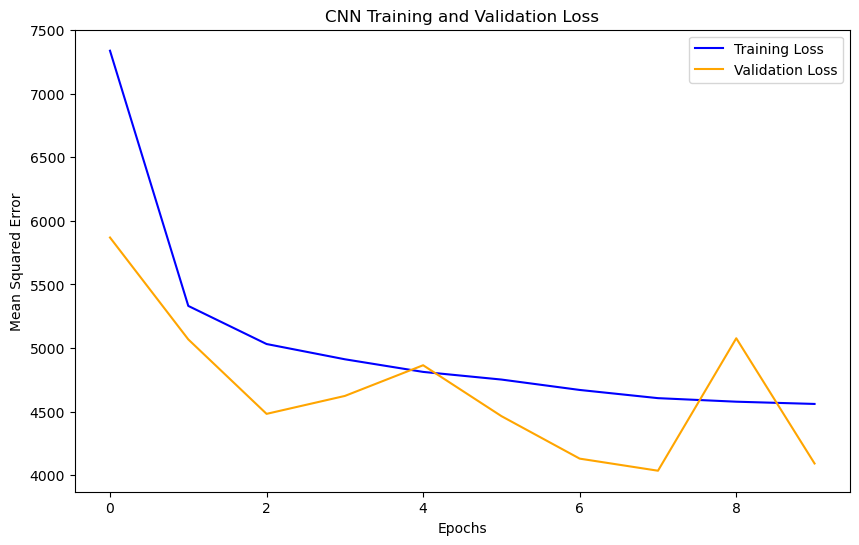

In [103]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='orange')
plt.title("CNN Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()


### LSTM

In [149]:
# Reshape Data for LSTM
# timestep is the sequence in which we wnat the data to go to model
timesteps = 1
X_train_lstm = X_train.values.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], timesteps, X_test.shape[1])

In [151]:
# Train
history3 = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step - loss: 9131.6328 - mae: 66.3810 - val_loss: 5479.2163 - val_mae: 45.8994
Epoch 2/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 5767.0859 - mae: 51.1865 - val_loss: 5908.9238 - val_mae: 45.7506
Epoch 3/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - loss: 5121.7500 - mae: 47.0972 - val_loss: 6115.5425 - val_mae: 46.0287
Epoch 4/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 5146.7305 - mae: 47.0277 - val_loss: 4856.9971 - val_mae: 41.5798
Epoch 5/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 4986.7563 - mae: 46.4039 - val_loss: 5579.3911 - val_mae: 44.1163
Epoch 6/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - loss: 4853.6484 - mae: 45.5865 - val_loss: 5241.2026 - val_mae: 42.4536
Epoch 7/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 4911.8403 - mae: 45.6293 - val_loss: 4948.5127 - val_mae: 41.7943
Epoch 8/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 4826.1489 - mae: 45.4214 -

In [152]:
y_train_pred_lstm = lstm_model.predict(X_train_lstm).flatten()
y_test_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Calculate R² scores
r2_train_lstm = r2_score(y_train, y_train_pred_lstm)
r2_test_lstm = r2_score(y_test, y_test_pred_lstm)

print(f"LSTM Train R²: {r2_train_lstm}")
print(f"LSTM Test R²: {r2_test_lstm}")

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
LSTM Train R²: 0.4735122323036194
LSTM Test R²: 0.4805787205696106


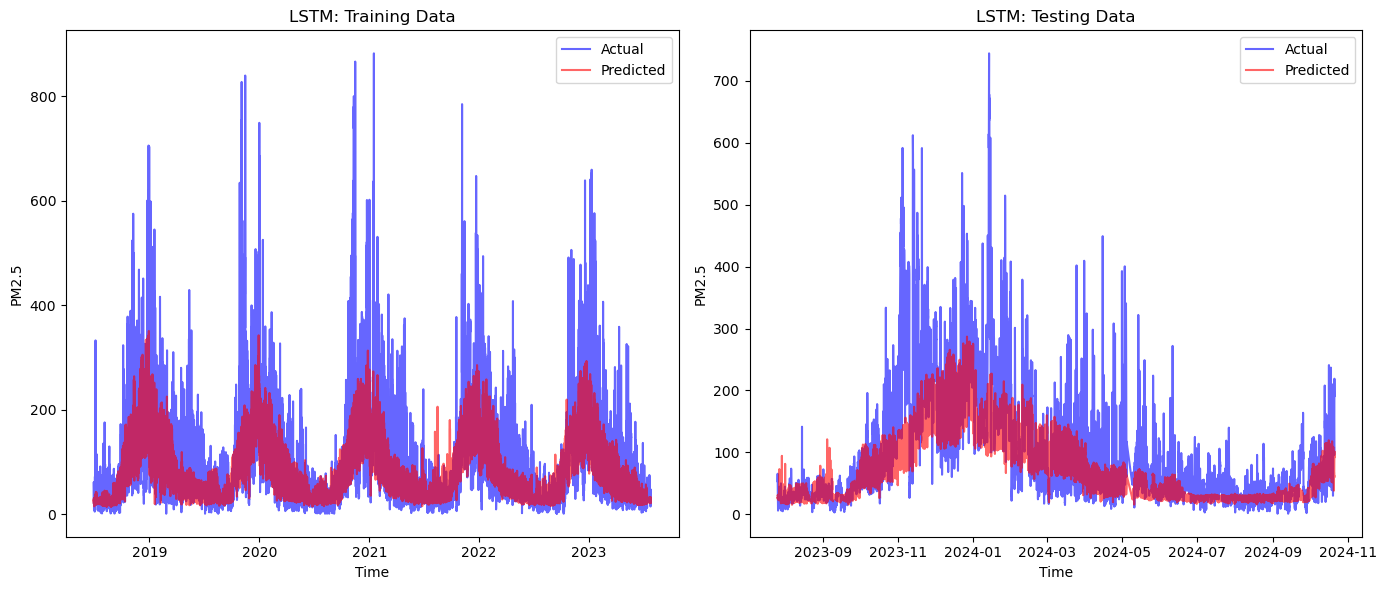

In [153]:
# Visualization for LSTM
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
plt.plot(train_data.index, y_train, label='Actual', alpha=0.6, color='blue')
plt.plot(train_data.index, y_train_pred_lstm, label='Predicted', alpha=0.6, color='red')
plt.title("LSTM: Training Data")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.plot(test_data.index, y_test, label='Actual', alpha=0.6, color='blue')
plt.plot(test_data.index, y_test_pred_lstm, label='Predicted', alpha=0.6, color='red')
plt.title("LSTM: Testing Data")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()

plt.tight_layout()
plt.show()

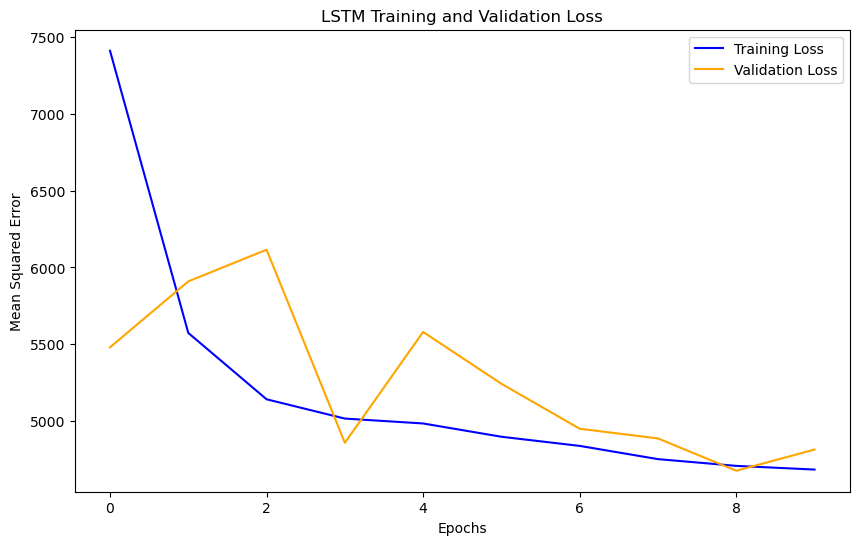

In [154]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history3.history['loss'], label='Training Loss', color='blue')
plt.plot(history3.history['val_loss'], label='Validation Loss', color='orange')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()


#### With Time stamps

In [172]:
timesteps = 3

# create sequence
def create_sequence(features, target, timesteps):
    X, y = [], []
    for i in range(len(features) - timesteps):
        X.append(features[i:i + timesteps])
        y.append(target[i + timesteps])
    return np.array(X), np.array(y)

# apply fucntion to create sequence
X_train_lstm_t, y_train_lstm_t = create_sequence(X_train, y_train['PM2.5 (µg/m³)'], timesteps)
X_test_lstm_t, y_test_lstm_t = create_sequence(X_test, y_test['PM2.5 (µg/m³)'], timesteps)

print(f"X_train_lstm shape: {X_train_lstm_t.shape}")  # (samples, timesteps, features)
print(f"y_train_lstm shape: {y_train_lstm_t.shape}")

/var/folders/2b/njy3nncn4y9_s7lg5v4x7b7r0000gn/T/ipykernel_82902/987581417.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(target[i + timesteps])


X_train_lstm shape: (42069, 3, 12)
y_train_lstm shape: (42069,)


In [178]:
# Define LSTM
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, X_train_lstm.shape[2]), 
         return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# compile
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [179]:
# Train
history4 = lstm_model.fit(
    X_train_lstm_t, y_train_lstm_t,
    validation_data=(X_test_lstm_t, y_test_lstm_t),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9155.8867 - mae: 66.5843 - val_loss: 5575.1353 - val_mae: 44.5942
Epoch 2/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - loss: 5033.4321 - mae: 45.9283 - val_loss: 5061.5010 - val_mae: 41.9149
Epoch 3/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - loss: 4626.0488 - mae: 43.6452 - val_loss: 5601.1611 - val_mae: 43.6739
Epoch 4/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - loss: 4381.0068 - mae: 42.1099 - val_loss: 4789.8472 - val_mae: 39.8837
Epoch 5/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - loss: 4473.9570 - mae: 42.0894 - val_loss: 4813.4385 - val_mae: 40.0643
Epoch 6/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 4332.3906 - mae: 41.4822 - val_loss: 5644.3979 - val_mae: 43.6962
Epoch 7/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 4050.7415 - mae: 40.4181 - val_loss: 3656.4033 - val_mae: 36.2452
Epoch 8/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 4255.6772 - mae: 41.3823 - v

In [180]:
X_train_lstm_t.shape[0] == y_train_lstm_t.shape[0]

True

In [181]:
# Make predictions
y_train_pred_lstm_t = lstm_model.predict(X_train_lstm_t).flatten()
y_test_pred_lstm_t = lstm_model.predict(X_test_lstm_t).flatten()


# Calculate R² scores
r2_train_lstm = r2_score(y_train_lstm_t, y_train_pred_lstm_t)
r2_test_lstm = r2_score(y_test_lstm_t, y_test_pred_lstm_t)

print(f"LSTM Train R²: {r2_train_lstm}")
print(f"LSTM Test R²: {r2_test_lstm}")

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
LSTM Train R²: 0.4582113964660245
LSTM Test R²: 0.45514102868395234


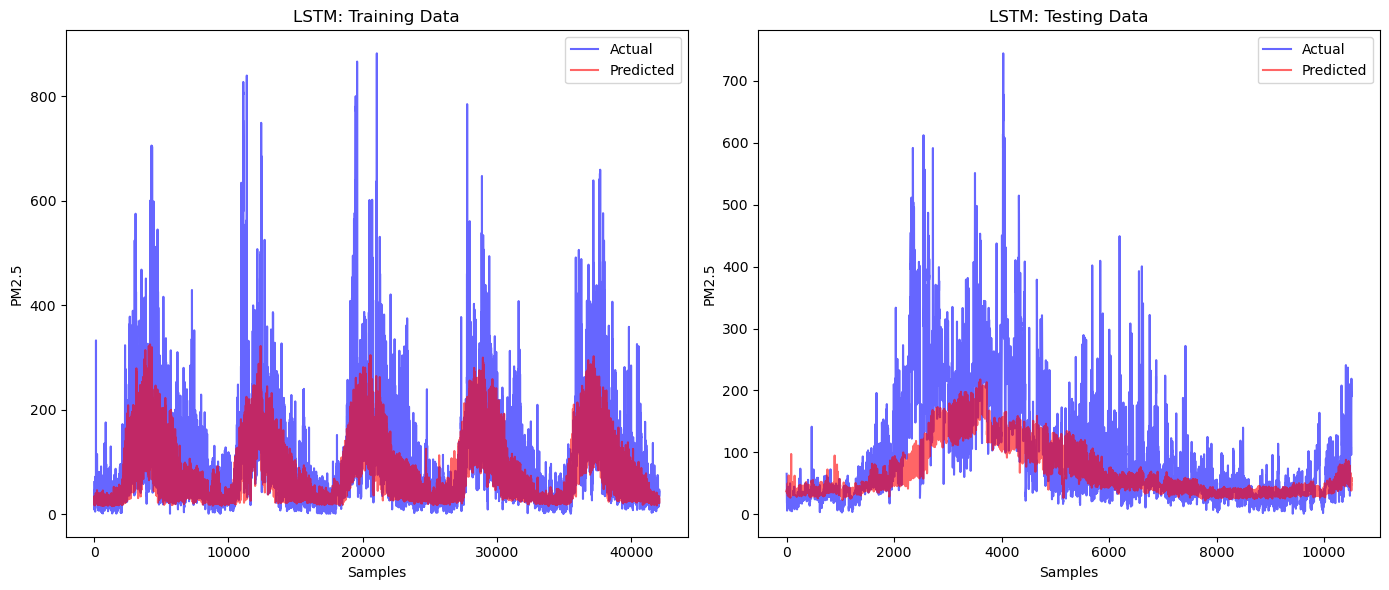

In [130]:
# Visualization for LSTM
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train_lstm_t)), y_train_lstm_t, label='Actual', alpha=0.6, color='blue')
plt.plot(range(len(y_train_pred_lstm_t)), y_train_pred_lstm_t, label='Predicted', alpha=0.6, color='red')
plt.title("LSTM: Training Data")
plt.xlabel("Samples")
plt.ylabel("PM2.5")
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test_lstm_t)), y_test_lstm_t, label='Actual', alpha=0.6, color='blue')
plt.plot(range(len(y_test_pred_lstm)), y_test_pred_lstm, label='Predicted', alpha=0.6, color='red')
plt.title("LSTM: Testing Data")
plt.xlabel("Samples")
plt.ylabel("PM2.5")
plt.legend()

plt.tight_layout()
plt.show()

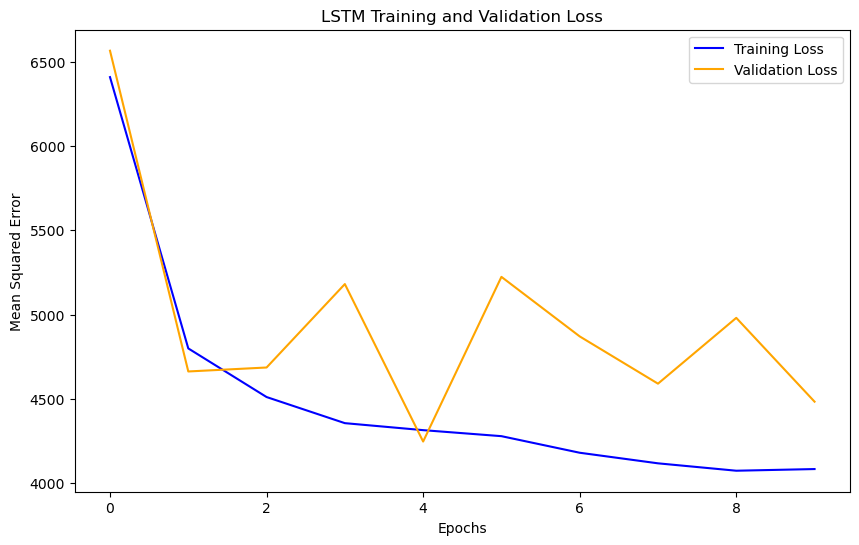

In [131]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history4.history['loss'], label='Training Loss', color='blue')
plt.plot(history4.history['val_loss'], label='Validation Loss', color='orange')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

#### CNN With LSTM

In [191]:
from keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten

In [185]:
X_train_hybrid, y_train_hybrid = create_sequence(X_train, y_train['PM2.5 (µg/m³)'], timesteps)
X_test_hybrid, y_test_hybrid = create_sequence(X_test, y_test['PM2.5 (µg/m³)'], timesteps)

/var/folders/2b/njy3nncn4y9_s7lg5v4x7b7r0000gn/T/ipykernel_82902/987581417.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(target[i + timesteps])


In [186]:
# Check the shapes
print(f"X_train_hybrid shape: {X_train_hybrid.shape}")  # (samples, timesteps, features)
print(f"y_train_hybrid shape: {y_train_hybrid.shape}")

X_train_hybrid shape: (42069, 3, 12)
y_train_hybrid shape: (42069,)


In [194]:
# LSTM and CNN
hybrid_model = Sequential([
    # Convolution layer
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, X_train_hybrid.shape[2])),
    Dropout(0.2),

    # LSTM
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

hybrid_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/anaconda3/envs/learnEnv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [195]:
history5 = hybrid_model.fit(
    X_train_hybrid, y_train_hybrid,
    validation_data=(X_test_hybrid, y_test_hybrid),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8909.6621 - mae: 65.9215 - val_loss: 5253.0249 - val_mae: 47.9008
Epoch 2/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5316.0771 - mae: 48.2407 - val_loss: 5515.9629 - val_mae: 43.8971
Epoch 3/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4897.6016 - mae: 44.7203 - val_loss: 5148.7759 - val_mae: 41.5394
Epoch 4/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4621.2573 - mae: 43.5960 - val_loss: 6256.3789 - val_mae: 46.1686
Epoch 5/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4480.0562 - mae: 42.5669 - val_loss: 4872.6357 - val_mae: 40.4174
Epoch 6/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4314.9141 - mae: 41.8770 - val_loss: 5752.6572 - val_mae: 44.2137
Epoch 7/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4431.0107 - mae: 41.9499 - val_loss: 4836.6743 - val_mae: 39.8271
Epoch 8/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4332.9917 - mae: 41.4224 - val_loss: 6705.

In [196]:
# Make predictions
y_train_pred_hybrid = hybrid_model.predict(X_train_hybrid).flatten()
y_test_pred_hybrid = hybrid_model.predict(X_test_hybrid).flatten()

# Calculate R² scores
r2_train_hybrid = r2_score(y_train_hybrid, y_train_pred_hybrid)
r2_test_hybrid = r2_score(y_test_hybrid, y_test_pred_hybrid)

print(f"Hybrid Model Train R²: {r2_train_hybrid}")
print(f"Hybrid Model Test R²: {r2_test_hybrid}")


1315/1315 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
Hybrid Model Train R²: 0.4244373780670897
Hybrid Model Test R²: 0.36010826169681776


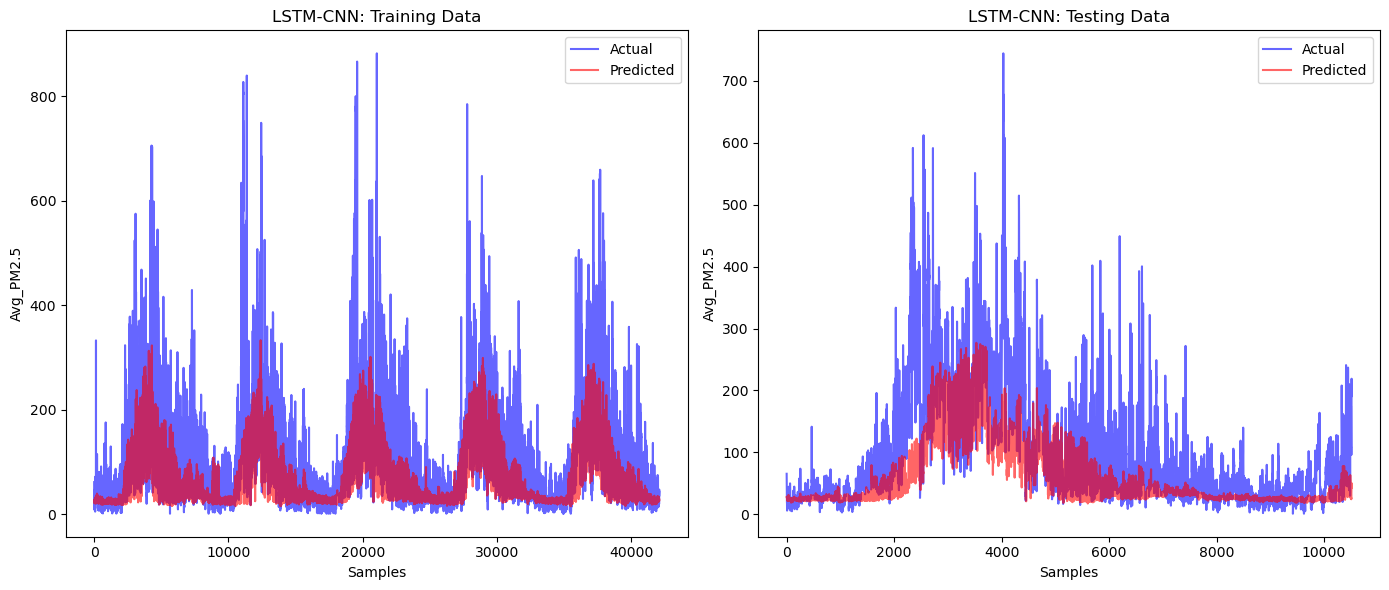

In [197]:
# Visualization for Hybrid Model
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train_hybrid)), y_train_hybrid, label='Actual', alpha=0.6, color='blue')
plt.plot(range(len(y_train_pred_hybrid)), y_train_pred_hybrid, label='Predicted', alpha=0.6, color='red')
plt.title("LSTM-CNN: Training Data")
plt.xlabel("Samples")
plt.ylabel("Avg_PM2.5")
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test_hybrid)), y_test_hybrid, label='Actual', alpha=0.6, color='blue')
plt.plot(range(len(y_test_pred_hybrid)), y_test_pred_hybrid, label='Predicted', alpha=0.6, color='red')
plt.title("LSTM-CNN: Testing Data")
plt.xlabel("Samples")
plt.ylabel("Avg_PM2.5")
plt.legend()

plt.tight_layout()
plt.show()

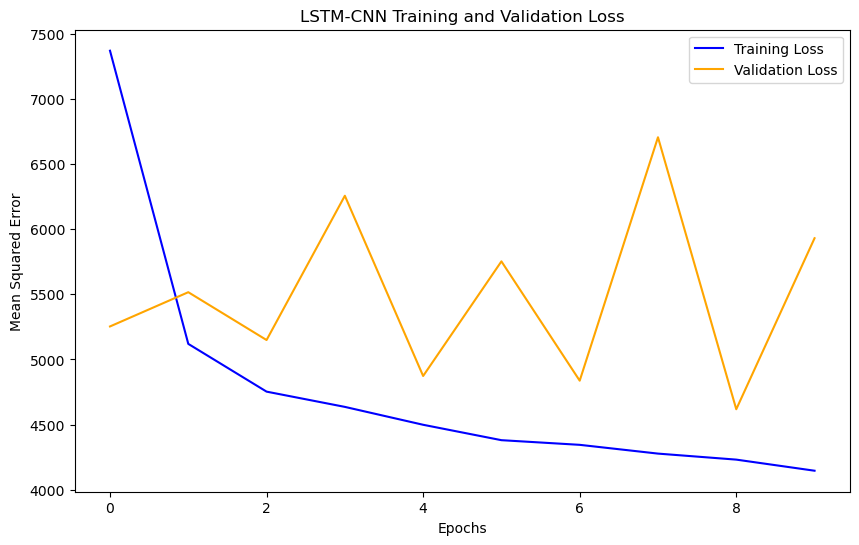

In [199]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history5.history['loss'], label='Training Loss', color='blue')
plt.plot(history5.history['val_loss'], label='Validation Loss', color='orange')
plt.title("LSTM-CNN Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

## ForeCasting